In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.ticker import *
from pathlib import Path
plt.style.use('plot_styles.txt')
import  matplotlib.font_manager
fpath = '/usr/local/share/fonts/HelveticaNeue.ttf'

# colorWheel =['#329932',
#             '#ff6961',
#             'b',
#             '#6a3d9a',
#             #'#fb9a99',
#             #'#e31a1c',
#             #'#fdbf6f',
#             #'#ff7f00',
#             #'#cab2d6',
#             #'#6a3d9a',
#             #'#ffff99',
#             #'#b15928',
#             #'#67001f',
#             '#b2182b',
#             #'#d6604d',
#             '#f4a582',
#             '#fddbc7',
#             '#f7f7f7',
#             '#d1e5f0',
#             '#92c5de',
#             '#4393c3',
#             '#2166ac',
#             '#053061']


colorWheel = ['#1F77B4', '#FF7F0E', '#2CA02C', '#D62728', '#9467BD', '#8C564B', '#E377C2', '#7F7F7F', '#BCBD22', '#17BECF']

curve_names = {
    'D': 'Parallel Dual Simplex',
    'DR': 'Dual Reducer',
    'GDR': 'Gurobi ILP',
    'SR': 'SketchRefine',
    'LSR': 'Progressive Shading',
    'DLV': 'Dynamic Low Variance'
}

lw=1
markersize=2
capsize=2
marker='o'
linestyle='-'
capsize=4
capthick=0.8
elinewidth=0.5
alpha=0.15
figsize=(10, 5)

plt.rcParams["font.family"] = "Helvetica Neue"

indexMap = {'GDR': 1, 'SR': 2, 'LSR': 0}
xOffsetMap = [0.8, 1.4, 1]

SMALL_SIZE = 12
MEDIUM_SIZE = 13
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


#markers = ['o', 'P', 'd', 'v', '^']

# A3

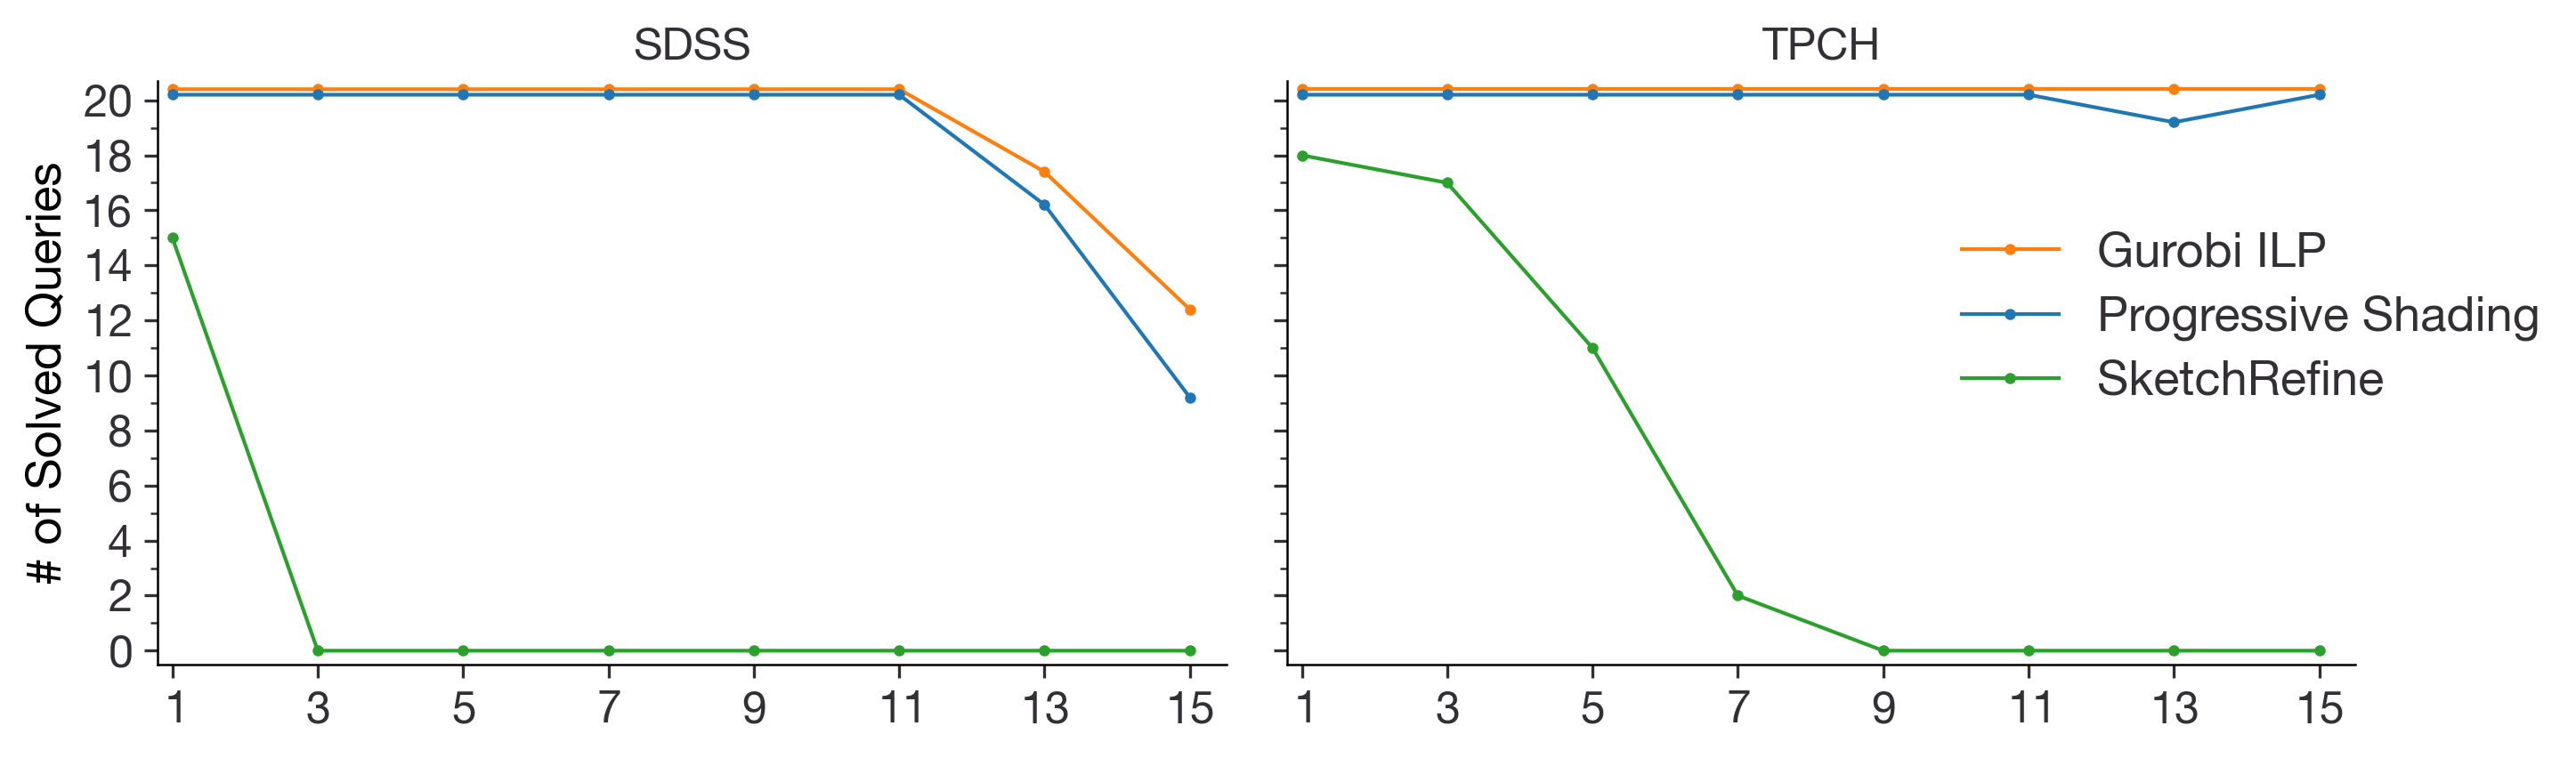

In [12]:
figsize=(10, 3)
data = pd.read_csv('A3.csv', names=['curve', 'x', 'y'])
data['solver'] = data['curve'].str.partition('_')[2].str.partition('_')[0]
data['dataset'] = data['curve'].str.partition('_')[0]
# data.curve.str.extract('^(?:[^_]*_){2}(.+)$')
data['dparam'] = data.curve.str.rpartition('_')[2]
df_err = data[data['dparam']=='igap']
df_acc = data[~(data['dparam']=='igap')]

df_acc_agg = df_acc.groupby(['dataset', 'solver', 'x', 'dparam'], as_index=False)['y'].sum()
df_err_bar = df_err.groupby(['dataset', 'solver', 'x'], as_index=False).agg([np.mean, np.max, np.min])
df_err_bar.columns = df_err_bar.columns.map('_'.join)
df_err_bar.reset_index(inplace=True)
df_err_bar['y_err_pos'] = df_err_bar['y_amax'] - df_err_bar['y_mean']
df_err_bar['y_err_neg'] = df_err_bar['y_mean'] - df_err_bar['y_amin']

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=figsize)
xticks = list(range(1, 16, 2))
dataset = ['ssds', 'tpch']
names = ['SDSS', 'TPCH']

for i, D in enumerate(dataset):
    df_acc_d = df_acc_agg[df_acc_agg['dataset']==D]
    df_err_d = df_err
#    ax = axs[0, i]
    ax = axs[i]
    df_gr = df_acc_d[(df_acc_d['solver']=='LSR') & (df_acc_d['dparam']=='P')]\
            .groupby(['dataset', 'solver', 'x'], as_index=False)['y'].sum()
    # Fitting GR solvability
    df_gr['y'] = 20
    if i == 0:
        df_gr.loc[6, 'y']=17
        df_gr.loc[7, 'y']=12
    df_lsr = df_acc_d[(df_acc_d['solver']=='LSR') & (df_acc_d['dparam']=='P')] \
            .groupby(['dataset', 'solver', 'x'], as_index=False)['y'].sum()
    df_sr = df_acc_d[(df_acc_d['solver']=='SR') & (df_acc_d['dparam']=='P')] \
            .groupby(['dataset', 'solver', 'x'], as_index=False)['y'].sum()
    
    # Impute missing data points explicitly with None value
    # if df_sr.shape[0] <= len(xticks):
    for x in xticks:
        new_row = pd.Series({'x': x, 'y': 0})
        if x not in df_sr.x.unique():
            df_sr = pd.concat([df_sr, new_row.to_frame().T], ignore_index=True)
        if x not in df_lsr.x.unique():
            df_lsr = pd.concat([df_lsr, new_row.to_frame().T], ignore_index=True)
        if x not in df_gr.x.unique():
            df_gr = pd.concat([df_gr, new_row.to_frame().T], ignore_index=True)
    
    ax.plot(
        df_gr['x'],
        df_gr['y']+0.4,
        color = colorWheel[indexMap['GDR']],
        linestyle=linestyle,
        lw=lw,
        marker=marker,
        markersize=markersize,
        markeredgecolor=colorWheel[indexMap['GDR']],
        label='Gurobi ILP'
    )
    ax.plot(
        df_lsr['x'],
        df_lsr['y']+0.2,
        color = colorWheel[indexMap['LSR']],
        lw=lw,
        linestyle=linestyle,
        marker=marker,
        markersize=markersize,
        markeredgecolor=colorWheel[indexMap['LSR']],
        label='Progressive Shading'
    )
    ax.plot(
        df_sr['x'],
        df_sr['y'],
        color = colorWheel[indexMap['SR']],
        lw=lw,
        linestyle=linestyle,
        marker=marker,
        markersize=markersize,
        markeredgecolor=colorWheel[indexMap['SR']],
        label='SketchRefine'
    )
    if i!=0:
        ax.yaxis.set_tick_params(labelleft=False)
    ax.set_title(names[i], loc='center')
    ax.set_ylim(top=20.7, bottom=-0.5)
    ax.set_yticks(range(0, 21, 2))
    ax.yaxis.set_minor_locator(AutoMinorLocator(2))
    ax.set_xlim(left=0.8, right=15.5)
    ax.set_xticks(xticks)

#     df_err_d = df_err_bar[df_err_bar['dataset']==D]
#     max_other = 0
#     max_lsr = 0
#     for solver in ['LSR', 'SR']:
#         df_curve_err = df_err_d[df_err_d['solver']==solver]
#         ax1 = axs[1, i]
#         ax1.errorbar(
#                 df_curve_err['x'], 
#                 df_curve_err['y_mean'], 
#                 yerr=[df_curve_err['y_err_neg'], df_curve_err['y_err_pos']],
#                 color=colorWheel[indexMap[solver]],
#                 linestyle=linestyle,
#                 linewidth=lw,
#                 marker=marker,
#                 markersize=markersize,
#                 markeredgecolor=colorWheel[indexMap[solver]],
#                 capsize=capsize,
#                 capthick=capthick,
#                 elinewidth=elinewidth,
#                 ecolor=colorWheel[indexMap[solver]]
#             )
# #         if i!=0:
# #             ax1.yaxis.set_tick_params(labelleft=False)
#         #ax1.set_xscale('log', base=10)
#         ax1.yaxis.set_major_formatter(FuncFormatter('{:.5g}'.format))
#         if i==0:
#             ax1.set_yscale('log', base=10)
#             ax1.set_ylim([0.99, 50000])
#         else:
#             ax1.set_ylim([0.99, 1.25])
#         ax1.set_xticks(xticks)
#         ax1.set_xlabel("Hardness")
#         ax1.set_xlim(right=15.5)
#         if solver == 'SR':
#             max_other = df_curve_err['x'].max()
#         else:
#             max_lsr = df_curve_err['x'].max()
#     ax1.axvspan(max_other, max_lsr, facecolor=colorWheel[indexMap['LSR']], edgecolor='white', alpha=alpha)
        
axs[0].set_ylabel('# of Solved Queries')
#axs[1].set_ylabel('Integrality Gap')
axs[1].legend(frameon=False, bbox_to_anchor=(0.6, 0.8))
plt.tight_layout()
plt.savefig('A3_final.png')

# A4 ssds

/tmp/ipykernel_2632824/2539528507.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_curve_err.sort_values(['x'], inplace=True)


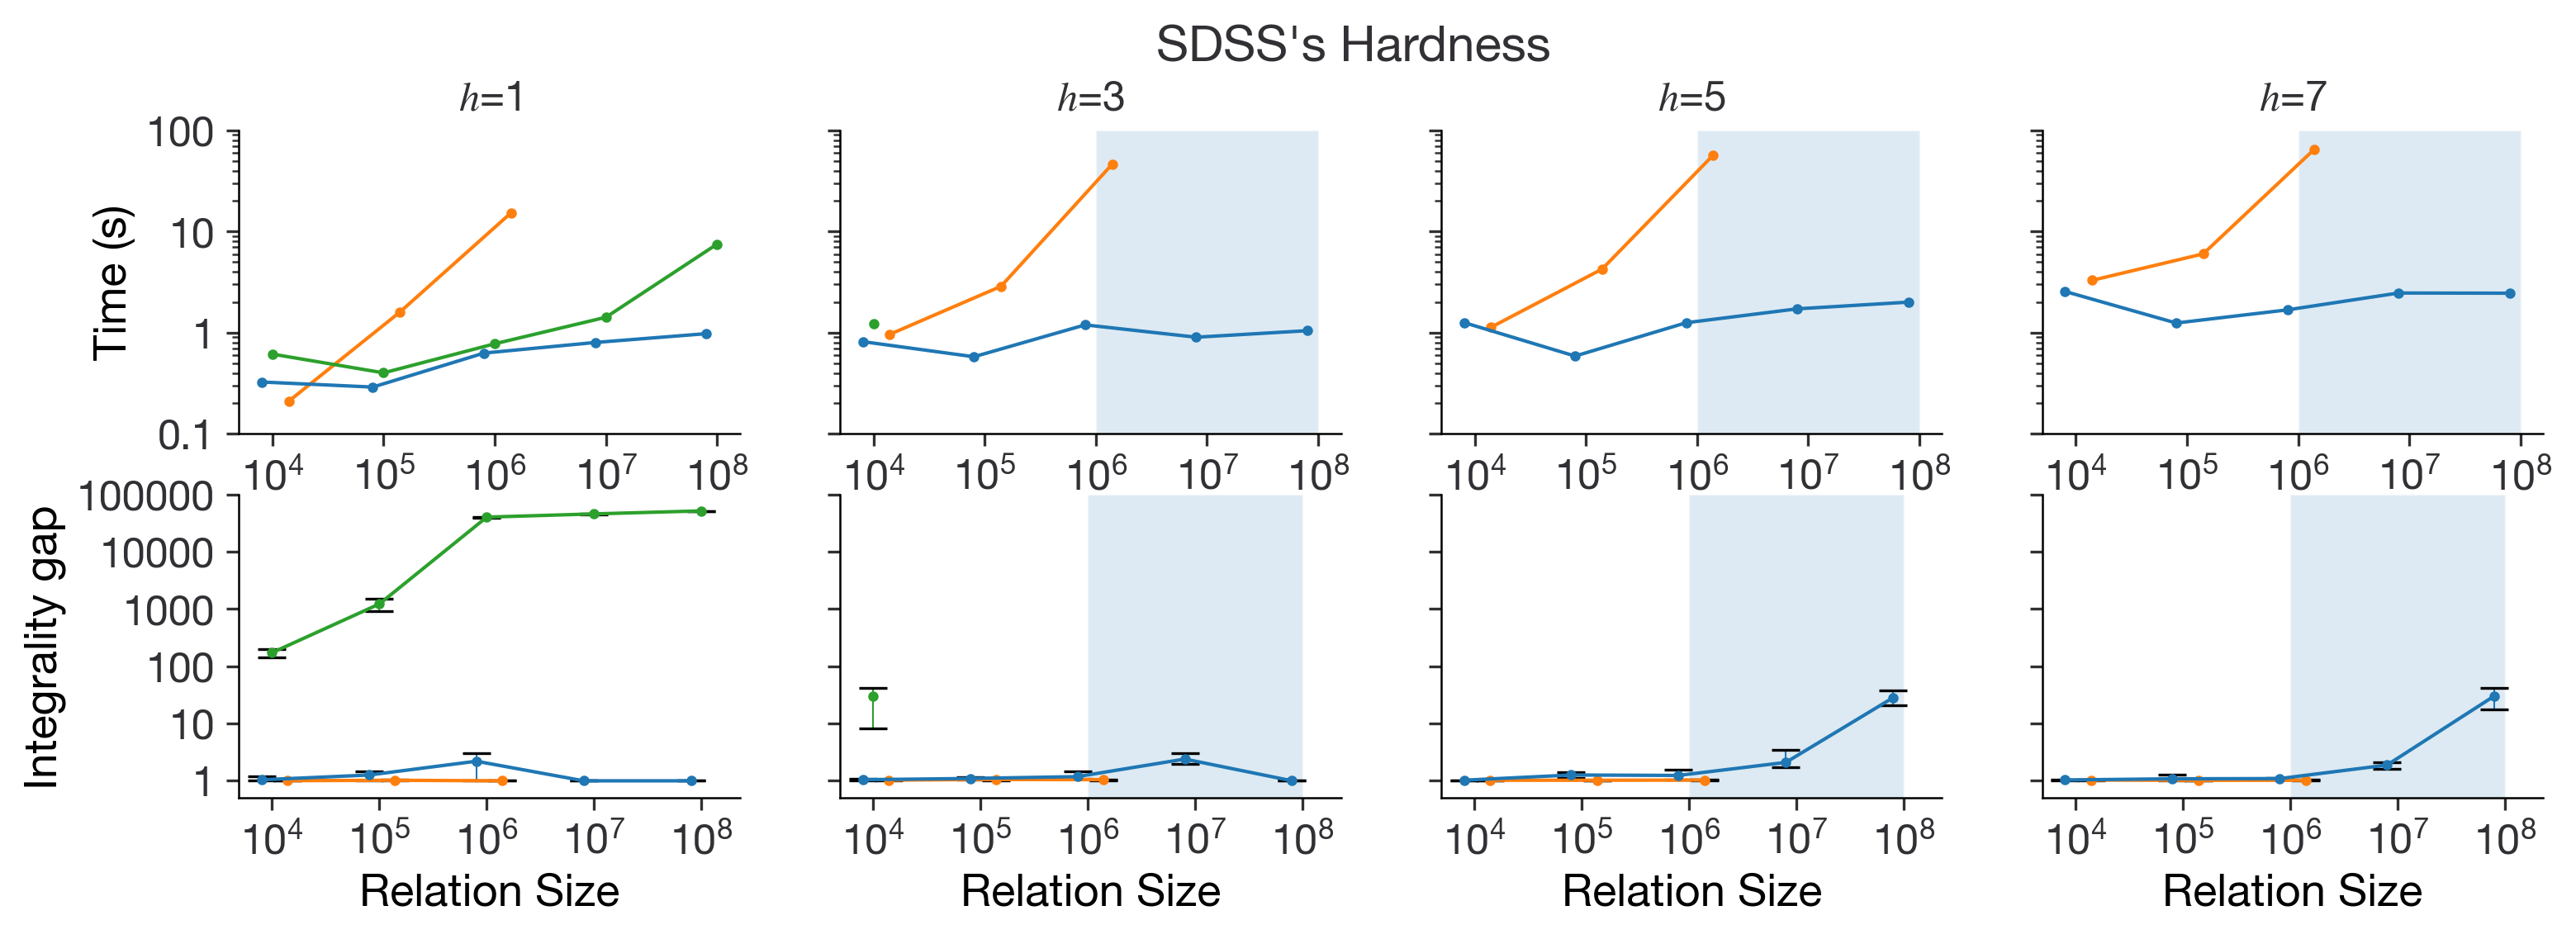

In [14]:
figsize=(12, 3.5)
csv_file = 'A4_ssds.csv'
is_ssds = 'ssds' in csv_file
data = pd.read_csv(csv_file, names=['curve', 'x', 'y'])
#data['x'] = dta['x'].astype(int)
data['solver'] = data['curve'].str.rpartition('_')[0].str.rpartition('_')[2]
data['H'] = data['curve'].str.rpartition('_H')[2].str.partition('_')[0]
df_time = data[data['curve'].str.contains('time')]
df_err = data[data['curve'].str.contains('igap')]

df_time_avg = df_time.groupby(['solver', 'H', 'x'], as_index=False).mean()
df_err_avg = df_err.groupby(['solver', 'H', 'x'], as_index=False).mean()
#df_err.y = df_err.y * 100
df_err_bar = df_err.groupby(['solver', 'H', 'x'], as_index=False).agg([np.mean, np.max, np.min])
df_err_bar.columns = df_err_bar.columns.map('_'.join)
df_err_bar.reset_index(inplace=True)
df_err_bar['y_err_pos'] = df_err_bar['y_amax'] - df_err_bar['y_mean']
df_err_bar['y_err_neg'] = df_err_bar['y_mean'] - df_err_bar['y_amin']

num_hardness = data['H'].nunique()
fig, axs = plt.subplots(nrows=2, ncols=num_hardness, figsize=figsize)
#xOffsetMap = [0.65, 1.4, 1]
xticks = df_time['x'].unique()
s_pos = np.array([np.logspace(0.8*x, 1.2*x, num=3) for x in xticks])

for idx, h in enumerate(data['H'].unique()):
    df_h = df_time_avg[df_time_avg['H'] == h]
    df_h_err = df_err_bar[df_err_avg['H'] == h]
    ax = axs[0, idx]
    ax1 = axs[1, idx]
    max_other = 0
    for i, curve in enumerate(df_h['solver'].unique()):
        df_curve = df_h[df_h['solver'] == curve]
        df_curve_err = df_h_err[df_h_err['solver'] == curve]
        ax.plot(
            df_curve['x']*xOffsetMap[indexMap[curve]],
            df_curve['y']/1000,
            color=colorWheel[indexMap[curve]],
            linestyle=linestyle,
            linewidth=lw,
            marker=marker,
            markersize=markersize,
            markeredgecolor=colorWheel[indexMap[curve]],
            label=curve_names[curve]
        )
        if idx!=0:
            ax.yaxis.set_tick_params(labelleft=False)
        ax.set_xscale('log', base=10)
        ax.set_yscale('log', base=10)
        ax.yaxis.set_major_formatter(ScalarFormatter())
        ax.tick_params(axis='x', which='major')
        #ax.set_xlabel('Relation Size')
        ax.set_ylim(bottom=0.1, top=10e1)
        ax.yaxis.set_major_formatter(FuncFormatter('{:.4g}'.format))
        #ax.yaxis.set_major_formatter(StrMethodFormatter('{x:.1f}'))
        #ax.yaxis.set_tick_params()
        ax.set_xticks(df_time['x'].unique())
        ax.set_title(f'$h$={h}', loc='center')
        if curve == 'LSR':
            max_lsr = df_curve['x'].max()
        else:
            max_other = max(df_curve['x'].max(), max_other)
        
        # Percentage Error Bar
        
        # Impute missing data points explicitly with None value
        if df_curve_err.shape[0] <= len(xticks):
            for x in xticks:
                if x not in df_curve_err.x.unique():
                    new_row = pd.Series({'solver': curve, 'x': x, 'H': h})
                    df_curve_err = pd.concat([df_curve_err, new_row.to_frame().T], ignore_index=True)
        df_curve_err.sort_values(['x'], inplace=True)
        
#         print("h", h)
#         print(df_curve_err['y_mean'])

        ax1.errorbar(
            df_curve_err['x']*xOffsetMap[indexMap[curve]], 
            df_curve_err['y_mean'], 
            yerr=[df_curve_err['y_err_neg'], df_curve_err['y_err_pos']],
            color=colorWheel[indexMap[curve]],
            linestyle=linestyle,
            linewidth=lw,
            marker=marker,
            markersize=markersize,
            markeredgecolor=colorWheel[indexMap[curve]],
            capsize=capsize,
            capthick=capthick,
            elinewidth=elinewidth,
            ecolor=colorWheel[indexMap[curve]],
            label=curve_names[curve]
        )
        if idx!=0:
            ax1.yaxis.set_tick_params(labelleft=False)
        ax1.set_xscale('log', base=10)
        if is_ssds:
            ax1.set_yscale('log', base=10)
            ax1.set_yticks([1,10,100,1000,10000,100000])
        ax1.yaxis.set_major_formatter(FuncFormatter('{:.6g}'.format))
        ax1.set_xticks(df_time['x'].unique())
#         ax1.set_xlabels(['10e4', '10e5', '10e6', '10e7', '10e8', '10e9'])
#         ax1.ticklabel_format(axis='x', stylr='sci')
        ax1.tick_params(axis='x', which='major')
        ax1.set_xlabel('Relation Size')
        if is_ssds:
            ax1.set_ylim(bottom=0.5, top=1e5)
        else:
            ax1.set_ylim(bottom=0.99, top=1.3)
    ax.axvspan(max_other, max_lsr, facecolor=colorWheel[indexMap['LSR']], edgecolor='white', alpha=alpha)
    ax1.axvspan(max_other, max_lsr, facecolor=colorWheel[indexMap['LSR']], edgecolor='white', alpha=alpha)
          
axs[0, 0].set_ylabel('Time (s)')
#axs[0, 0].set_yticks([10])
axs[1, 0].set_ylabel('Integrality gap')
#axs[1, 1].legend(frameon=False, bbox_to_anchor=(2.5, -0.4), ncols=3)
#axs[0, 0]
fig.supxlabel('SDSS\'s Hardness', x=0.5, y=0.95)
fig.savefig('A4_ssds_final.png')

/tmp/ipykernel_2225683/2441291488.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_curve_err.sort_values(['x'], inplace=True)


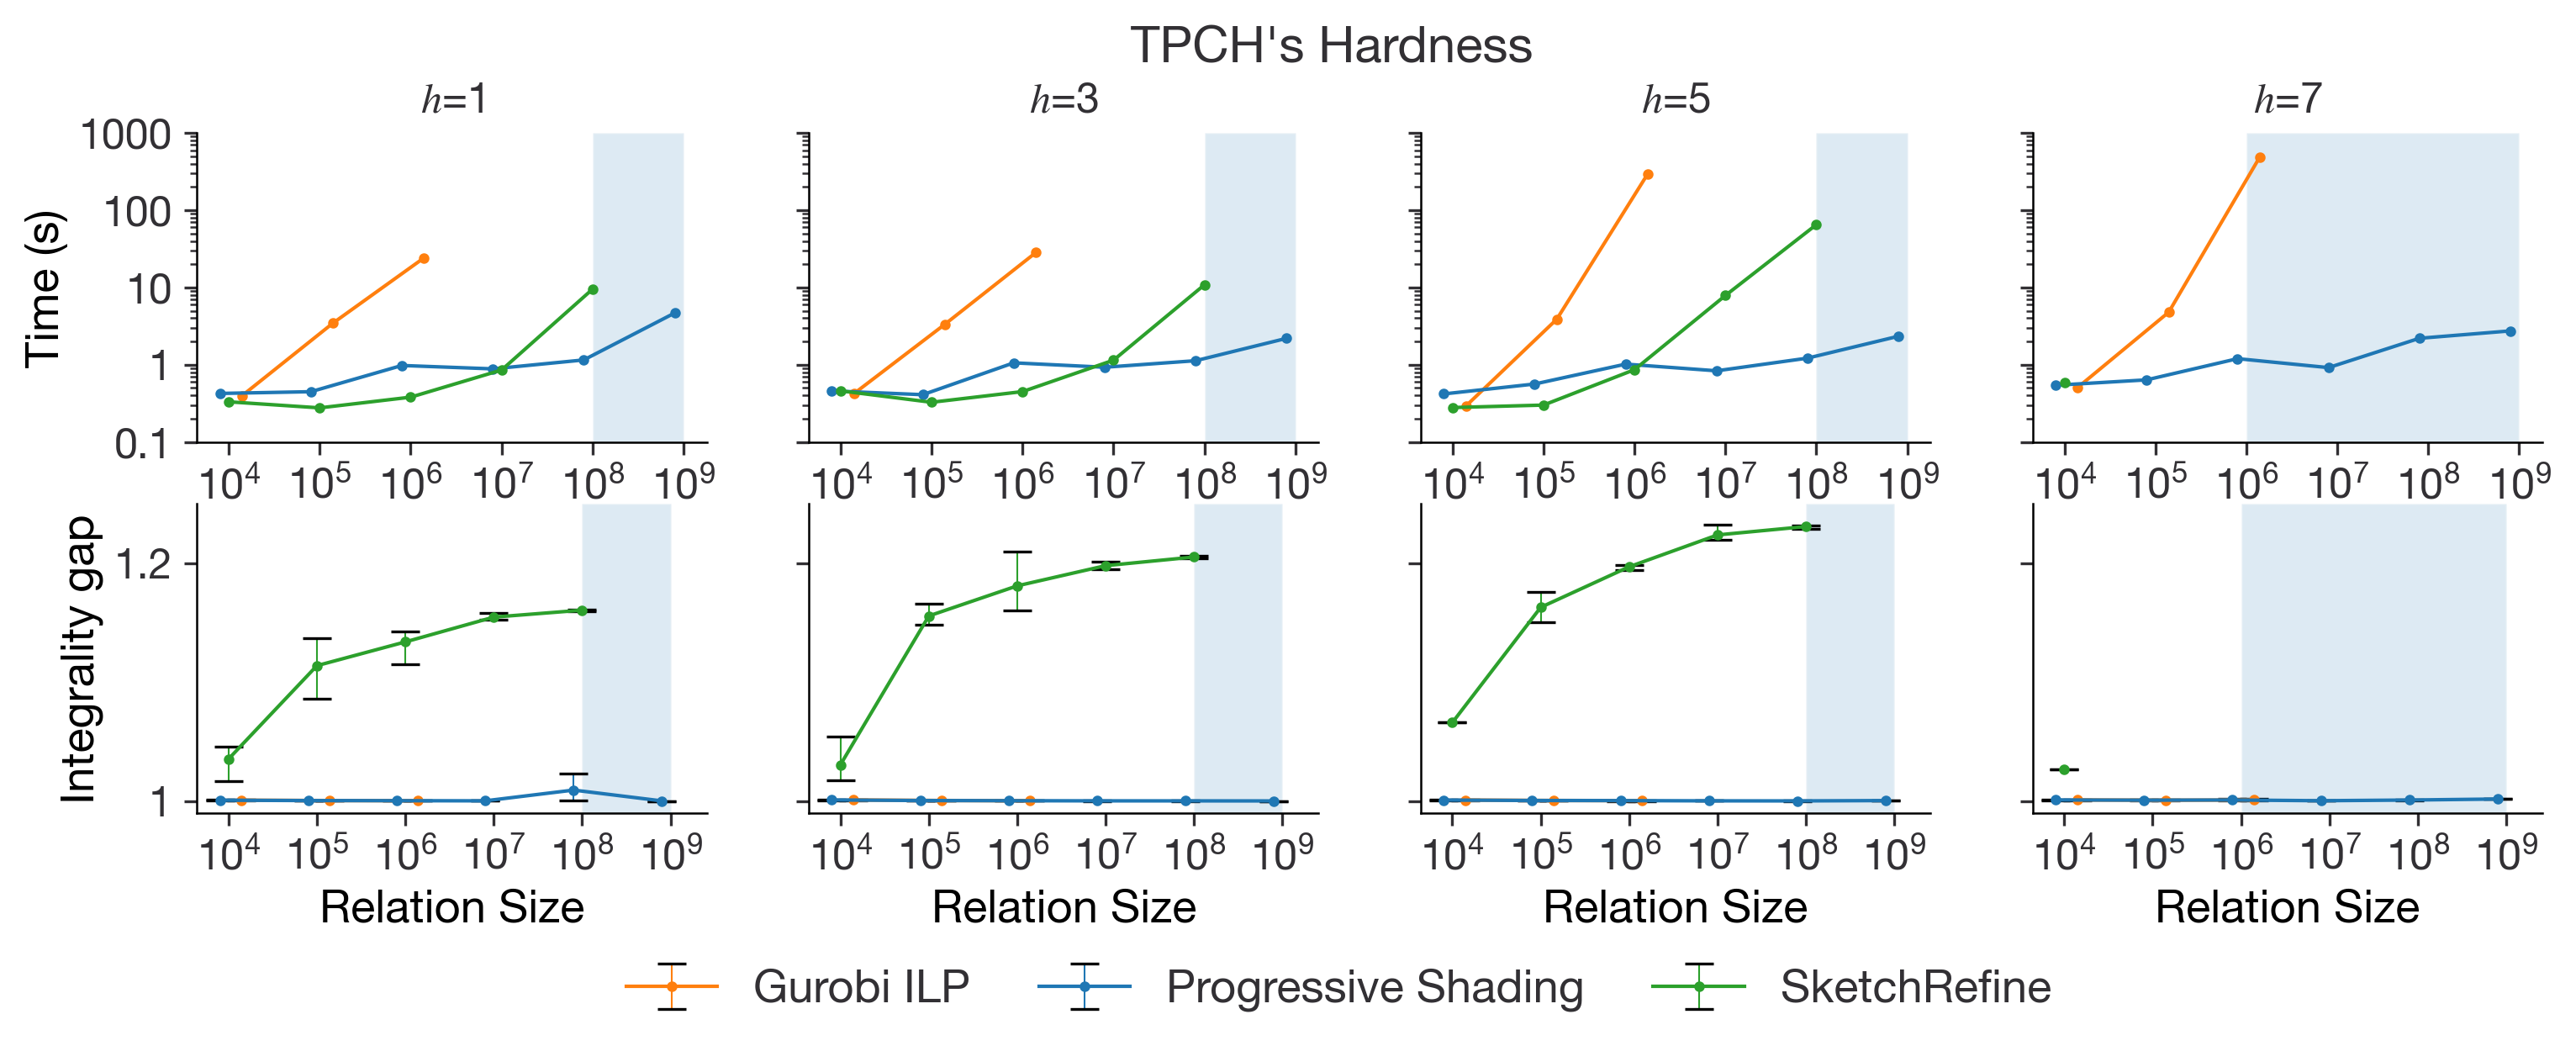

In [21]:
figsize=(12, 3.5)
csv_file = 'A4_tpch.csv'
is_ssds = 'ssds' in csv_file
data = pd.read_csv(csv_file, names=['curve', 'x', 'y'])
#data['x'] = dta['x'].astype(int)
data['solver'] = data['curve'].str.rpartition('_')[0].str.rpartition('_')[2]
data['H'] = data['curve'].str.rpartition('_H')[2].str.partition('_')[0]
df_time = data[data['curve'].str.contains('time')]
df_err = data[data['curve'].str.contains('igap')]

df_time_avg = df_time.groupby(['solver', 'H', 'x'], as_index=False).mean()
df_err_avg = df_err.groupby(['solver', 'H', 'x'], as_index=False).mean()
#df_err.y = df_err.y * 100
df_err_bar = df_err.groupby(['solver', 'H', 'x'], as_index=False).agg([np.mean, np.max, np.min])
df_err_bar.columns = df_err_bar.columns.map('_'.join)
df_err_bar.reset_index(inplace=True)
df_err_bar['y_err_pos'] = df_err_bar['y_amax'] - df_err_bar['y_mean']
df_err_bar['y_err_neg'] = df_err_bar['y_mean'] - df_err_bar['y_amin']

num_hardness = data['H'].nunique()
fig, axs = plt.subplots(nrows=2, ncols=num_hardness, figsize=figsize)
xticks = df_time['x'].unique()
s_pos = np.array([np.logspace(0.8*x, 1.2*x, num=3) for x in xticks])

for idx, h in enumerate(data['H'].unique()):
    df_h = df_time_avg[df_time_avg['H'] == h]
    df_h_err = df_err_bar[df_err_avg['H'] == h]
    ax = axs[0, idx]
    ax1 = axs[1, idx]
    max_other = 0
    for i, curve in enumerate(df_h['solver'].unique()):
        df_curve = df_h[df_h['solver'] == curve]
        df_curve_err = df_h_err[df_h_err['solver'] == curve]
        ax.plot(
            df_curve['x']*xOffsetMap[indexMap[curve]],
            df_curve['y']/1000,
            color=colorWheel[indexMap[curve]],
            linestyle=linestyle,
            linewidth=lw,
            marker=marker,
            markersize=markersize,
            markeredgecolor=colorWheel[indexMap[curve]],
            label=curve_names[curve]
        )
        if idx!=0:
            ax.yaxis.set_tick_params(labelleft=False)
        ax.set_xscale('log', base=10)
        ax.set_yscale('log', base=10)
        ax.yaxis.set_major_formatter(ScalarFormatter())
        ax.tick_params(axis='x', which='major')
        #ax.set_xlabel('Relation Size')
        ax.set_ylim(bottom=0.1, top=10e2)
        ax.yaxis.set_major_formatter(FuncFormatter('{:.4g}'.format))
        #ax.yaxis.set_major_formatter(StrMethodFormatter('{x:.1f}'))
        #ax.yaxis.set_tick_params()
        ax.set_xticks(df_time['x'].unique())
        ax.set_title(f'$h$={h}', loc='center')
        if curve == 'LSR':
            max_lsr = df_curve['x'].max()
        else:
            max_other = max(df_curve['x'].max(), max_other)
        
        # Percentage Error Bar
        
        # Impute missing data points explicitly with None value
        if df_curve_err.shape[0] <= len(xticks):
            for x in xticks:
                if x not in df_curve_err.x.unique():
                    new_row = pd.Series({'solver': curve, 'x': x, 'H': h})
                    df_curve_err = pd.concat([df_curve_err, new_row.to_frame().T], ignore_index=True)
        df_curve_err.sort_values(['x'], inplace=True)
        
#         print("h", h)
#         print(df_curve_err['y_mean'])

        ax1.errorbar(
            df_curve_err['x']*xOffsetMap[indexMap[curve]], 
            df_curve_err['y_mean'], 
            yerr=[df_curve_err['y_err_neg'], df_curve_err['y_err_pos']],
            color=colorWheel[indexMap[curve]],
            linestyle=linestyle,
            linewidth=lw,
            marker=marker,
            markersize=markersize,
            markeredgecolor=colorWheel[indexMap[curve]],
            capsize=capsize,
            capthick=capthick,
            elinewidth=elinewidth,
            ecolor=colorWheel[indexMap[curve]],
            label=curve_names[curve]
        )
        if idx!=0:
            ax1.yaxis.set_tick_params(labelleft=False)
        ax1.set_xscale('log', base=10)
        if is_ssds:
            ax1.set_yscale('log', base=10)
        ax1.yaxis.set_major_formatter(FuncFormatter('{:.5g}'.format))
        ax1.set_xticks(df_time['x'].unique())
#         ax1.set_xlabels(['10e4', '10e5', '10e6', '10e7', '10e8', '10e9'])
#         ax1.ticklabel_format(axis='x', stylr='sci')
        ax1.tick_params(axis='x', which='major')
        ax1.set_xlabel('Relation Size')
        if is_ssds:
            ax1.set_ylim(bottom=0.9, top=1e5)
        else:
            ax1.set_ylim(bottom=0.99, top=1.25)
    ax.axvspan(max_other, max_lsr, facecolor=colorWheel[indexMap['LSR']], edgecolor='white', alpha=alpha)
    ax1.axvspan(max_other, max_lsr, facecolor=colorWheel[indexMap['LSR']], edgecolor='white', alpha=alpha)
          
axs[0, 0].set_ylabel('Time (s)')
#axs[0, 0].set_yticks([10])
axs[1, 0].set_ylabel('Integrality gap')
axs[1, 1].legend(frameon=False, bbox_to_anchor=(2.5, -0.4), ncols=3)
#axs[0, 0]
fig.supxlabel('TPCH\'s Hardness', x=0.5, y=0.95)
# plt.tight_layout()
plt.savefig('A4_tpch.png')

In [27]:
# data = pd.read_csv('L1.csv', names=['curve', 'x', 'y'])
# data = data.groupby(['curve'], axis=0, as_index=False).mean()
# print(data)

            curve         x            y
0   ssds_LSR_dual  7.894737    98.573528
1     ssds_LSR_gb  7.894737  2325.355409
2   ssds_LSR_misc  7.894737   502.208523
3   ssds_LSR_read  7.894737   525.994254
4  ssds_LSR_total  7.894737  3452.131715
5   tpch_LSR_dual  7.789474   135.440595
6     tpch_LSR_gb  7.789474  1740.437381
7   tpch_LSR_misc  7.789474   385.822693
8   tpch_LSR_read  7.789474   384.404135
9  tpch_LSR_total  7.789474  2646.104804


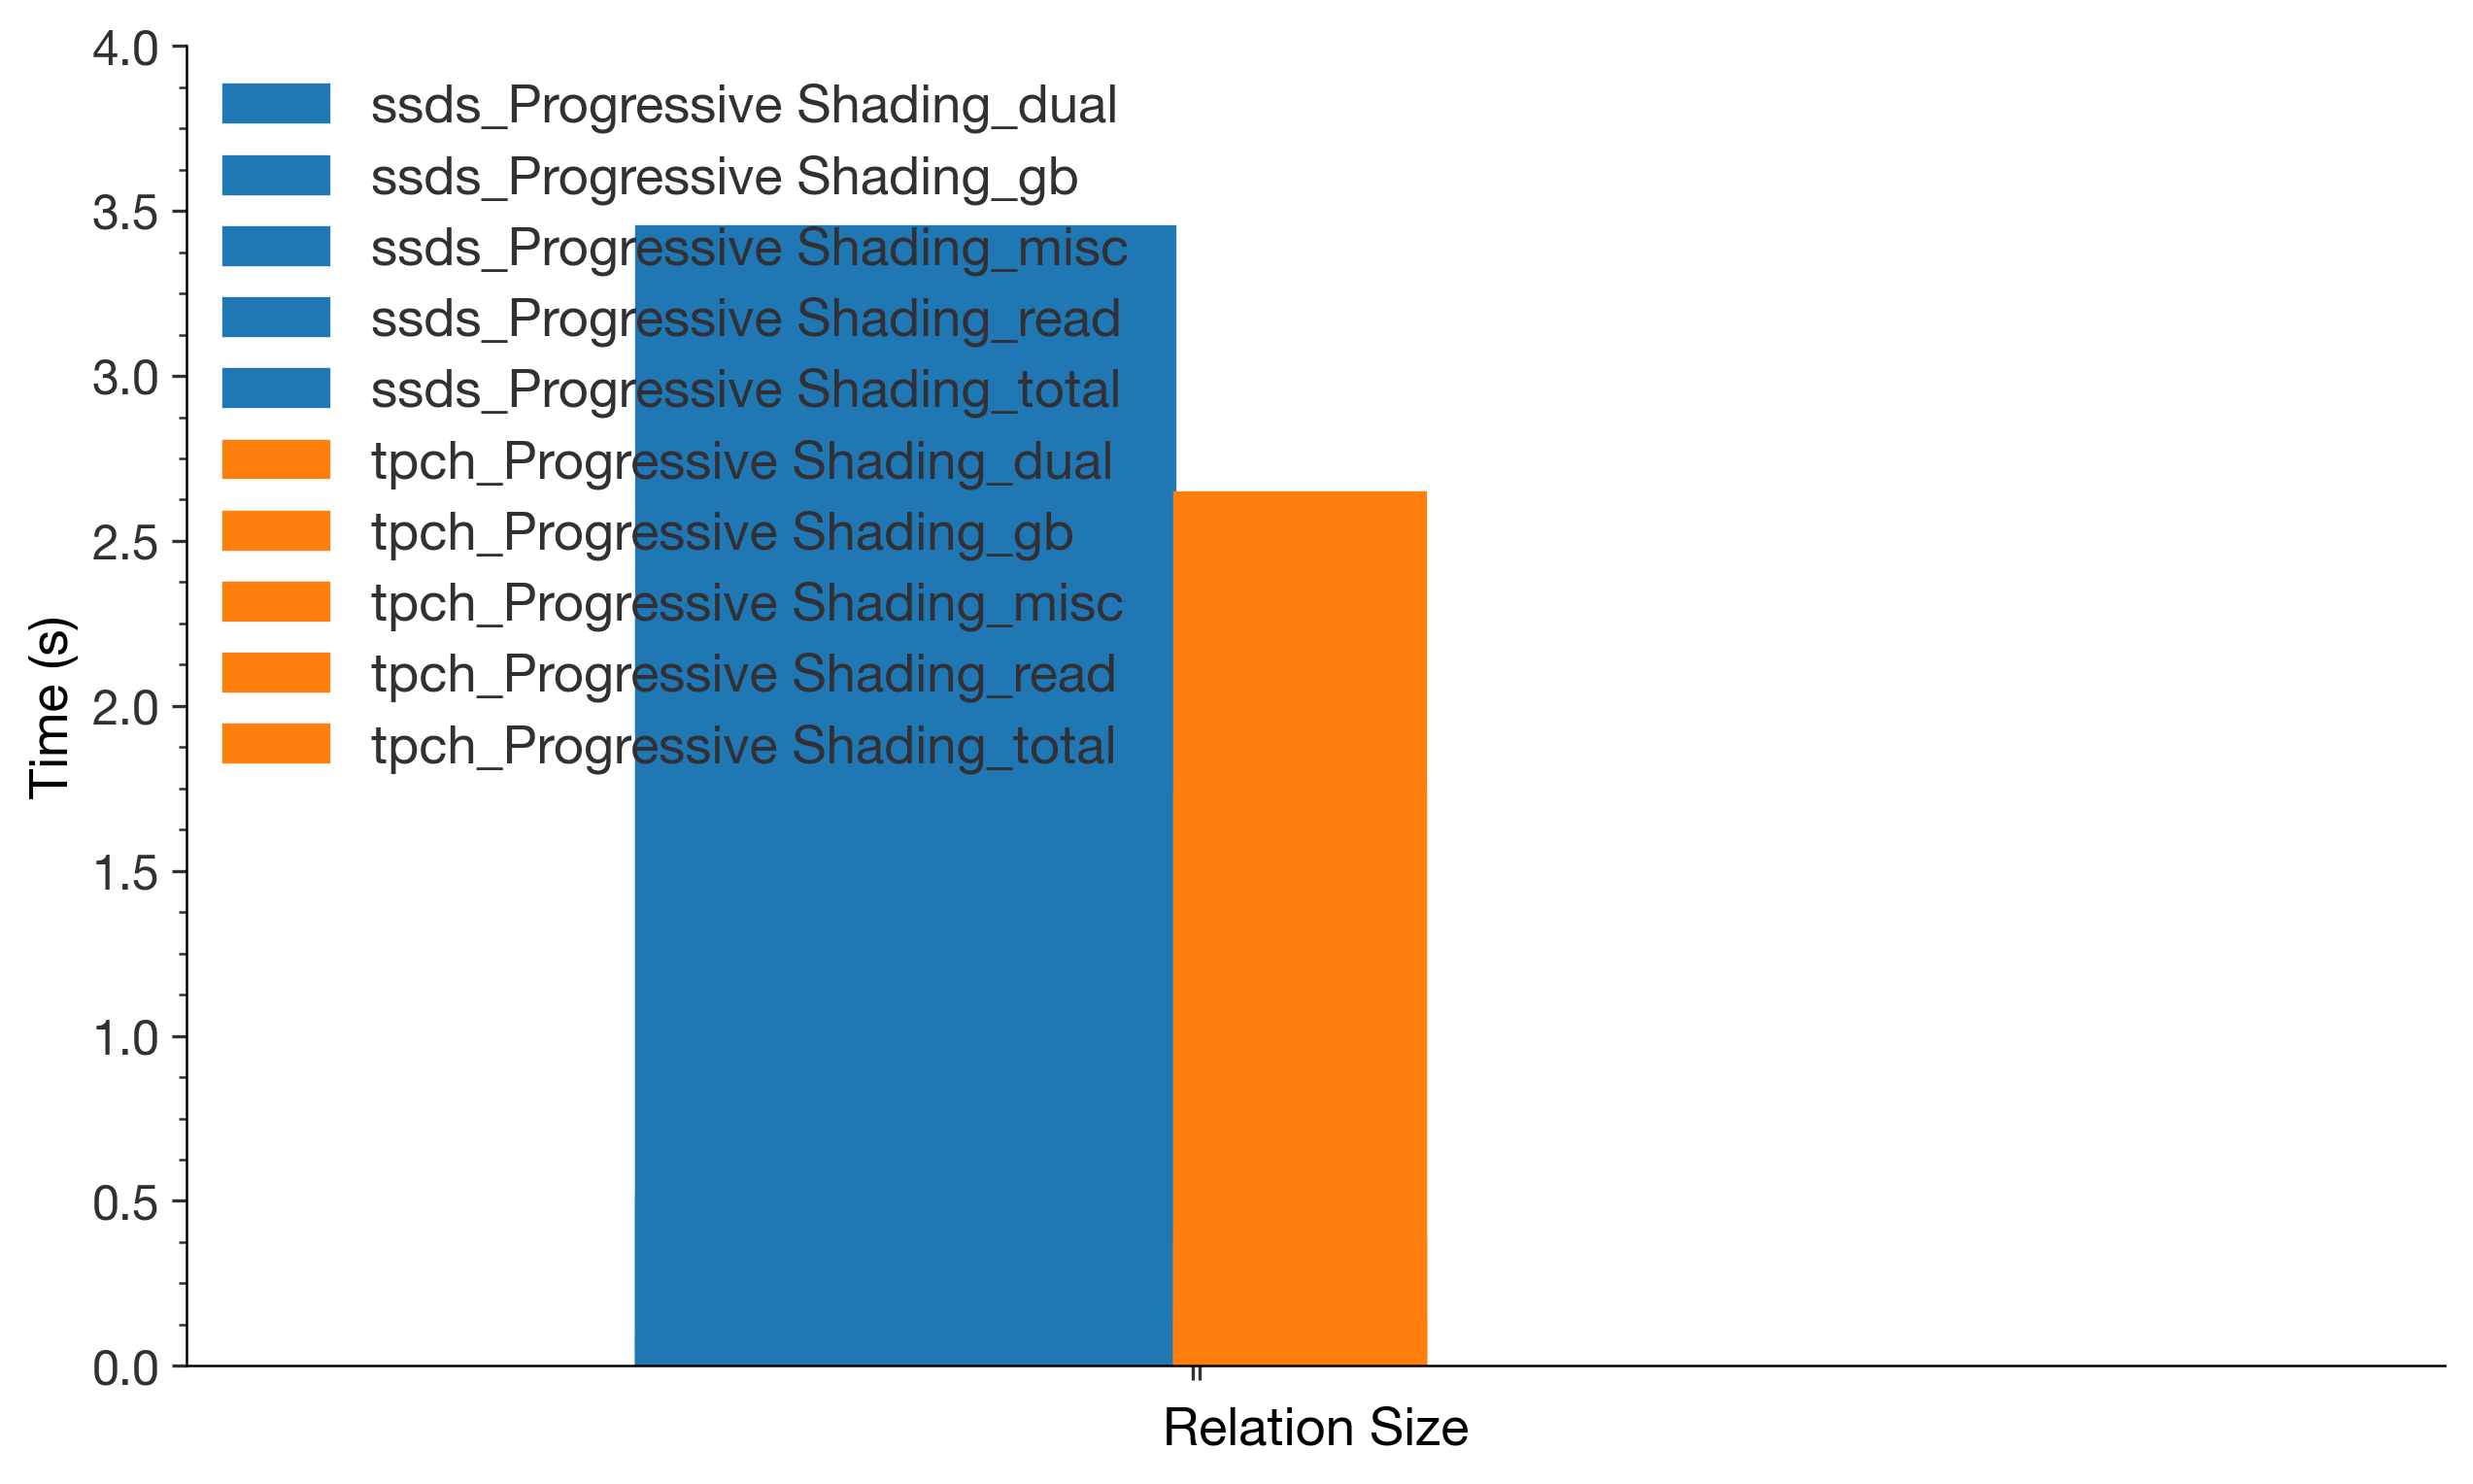

In [28]:
# fig, ax = plt.subplots(figsize=figsize)
# xticks = data['x'].unique()
# j=0
# datasets = ["ssds", "tpch"]
# for i, dataset in enumerate(datasets):
#     df_curve = data[data.curve.str.contains(dataset)]
#     cumval = 0
#     for k, curve in enumerate(df_curve['curve']):
#         ax.bar(
#             i*5+5,
#             df_curve.iloc[k]['y']/1000,
#             width=5,
#             bottom=cumval,
#             color=colorWheel[j],
#             edgecolor=colorWheel[j],
#             label=curve.replace('LSR', 'Progressive Shading'),
#             zorder=2.5
#             )
#     cumval += (df_curve.iloc[k]['y']/1000)
#     j+=1

        
# ax.set_xlabel('Relation Size')
# ax.set_xscale('log', base=10)
# #ax.xaxis.set_major_formatter(ScalarFormatter())
# ax.set_xticks(xticks)
# #ax.grid()
# #ax.set_ylim(top=100)
# #ax2.set_ylim(bottom=-0.1)
# plt.minorticks_off()
# ax.set_ylabel('Time (s)')
# #ax.set_xticks([1,2,4,8,16,32,80])
# #ax2.set_yticks([0, ])
# ax.yaxis.set_minor_locator(AutoMinorLocator(4))
# legend = ax.legend(loc='upper left', frameon=False)
# # ax.set_zorder(2.5)
# # ax2.set_zorder(2)
# # ax.spines['right'].set(visible=True)

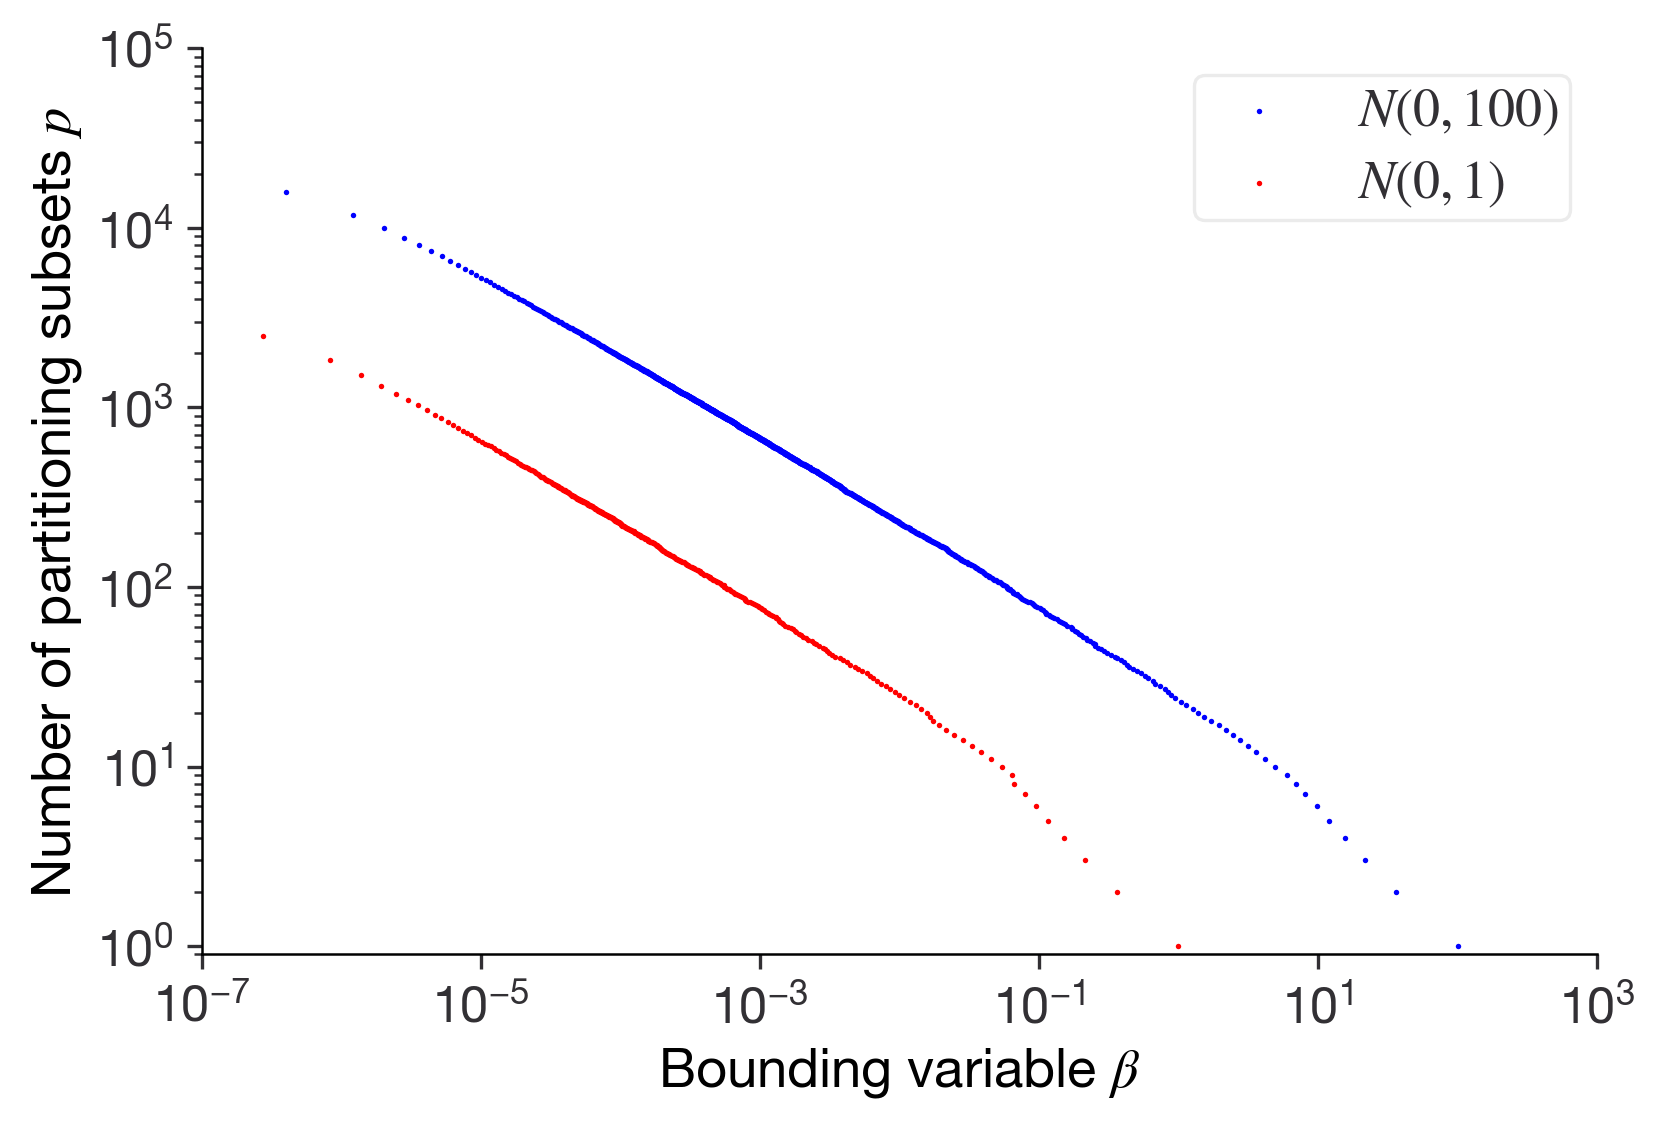

In [83]:
data1 = pd.read_csv('DLV.csv', names=['curve', 'x', 'y'])
p1 = data1[data1['curve']=='p']
data2 = pd.read_csv('DLV2.csv', names=['curve', 'x', 'y'])
p2 = data2[data2['curve']=='p']
plt.xscale('log')
plt.yscale('log')
plt.scatter(p1['x'], p1['y'], marker='.', s=1, color='blue', label=r'$N(0, 100)$')
plt.scatter(p2['x'], p2['y'], marker='.', s=1, color='red', label=r'$N(0, 1)$')
plt.legend()
plt.ylim(0.9, 10**5)
# locs, labels = plt.xticks()
# # labels[-1] = "ok"
# print(labels)
# plt.xticks([])
plt.ylabel(r"Number of partitioning subsets $p$")
plt.xlabel(r"Bounding variable $\beta$")
plt.show()

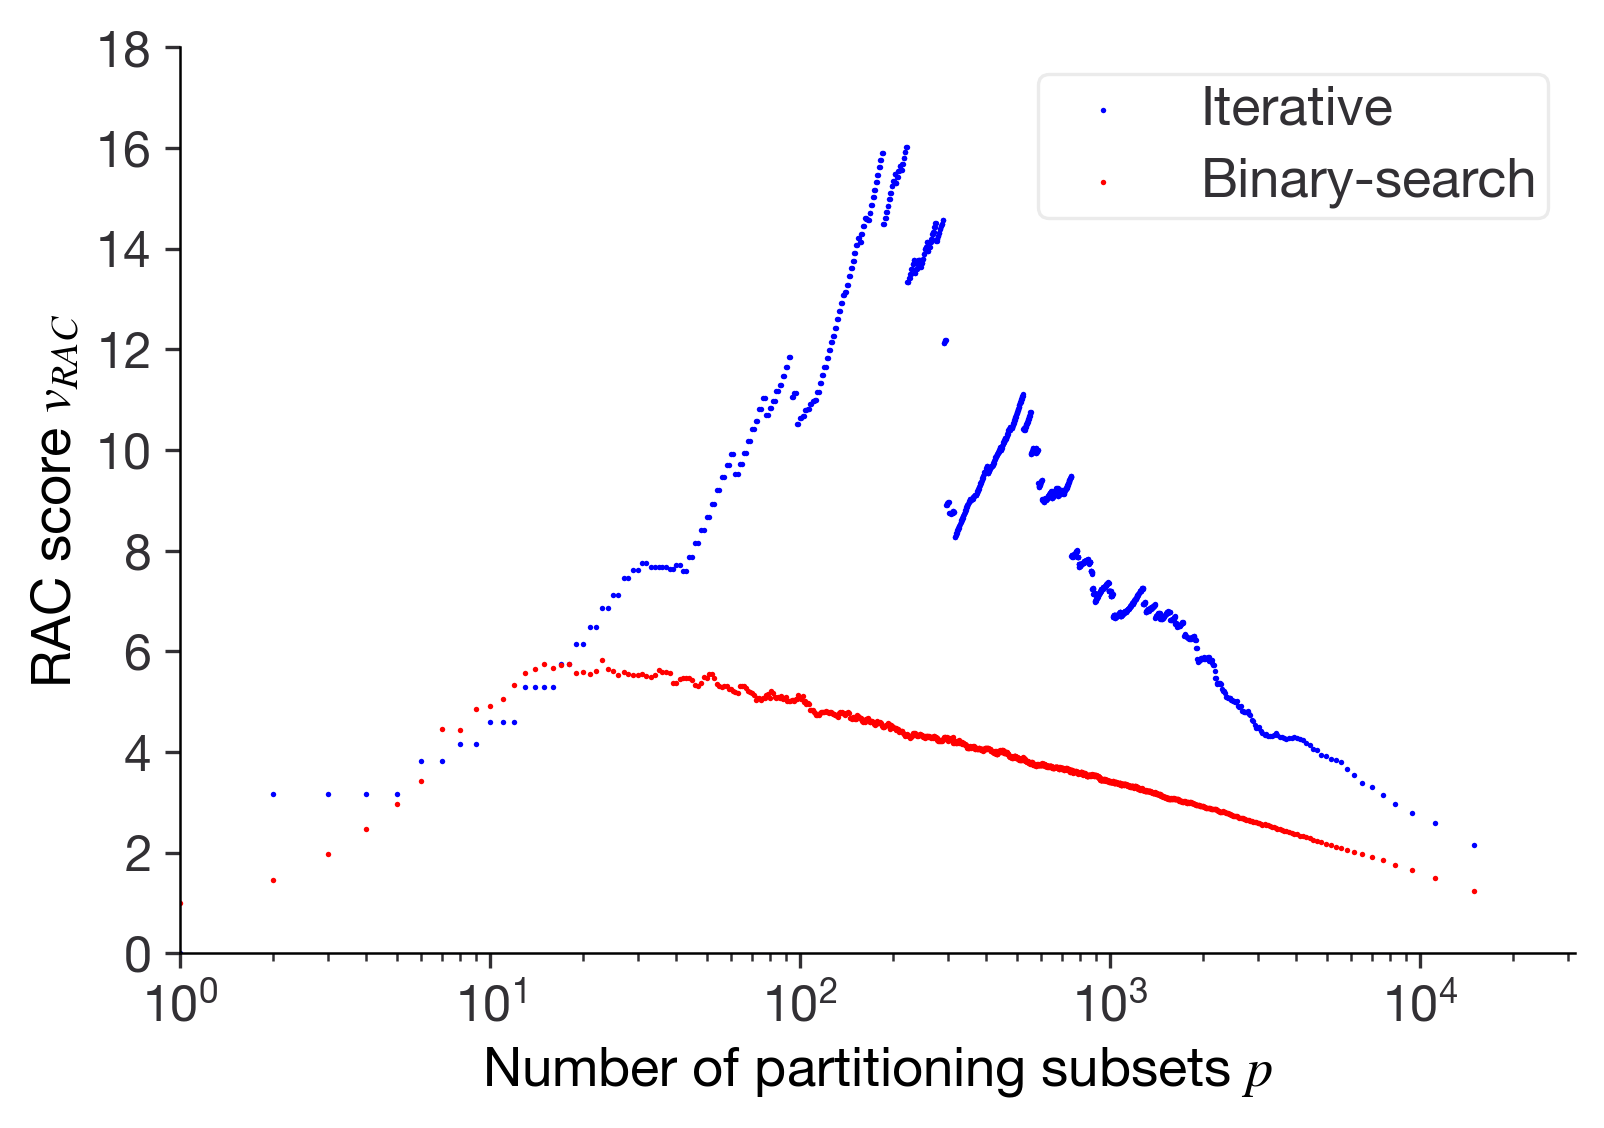

In [149]:
data = pd.read_csv('DLV3.csv', names=['curve', 'x', 'y'])
p1 = data[data['curve']=='rac']
p2 = data[data['curve']=='rwc']
p = data[data['curve']=='p']
plt.xscale('log')
y1, y2 = p1['y'], p2['y']
plt.scatter(p['y'], y1, marker='.', s=1, color='blue', label=r'Iterative')
plt.scatter(p['y'], y2, marker='.', s=1, color='red', label=r'Binary-search')
plt.legend()
plt.ylabel(r"RAC score $v_{RAC}$")
plt.xlabel(r"Number of partitioning subsets $p$")
plt.xlim(1, 10**4.5)
plt.ylim(0, 18)
plt.show()

In [95]:
data = pd.read_csv('A1.csv', names=['curve', 'x', 'y'])
data['y'] /= 1000
data = data.groupby(['curve', 'x'], axis=0, as_index=False).mean()
print(data)

   curve     x            y
0      D   1.0    97.624928
1      D   2.0    73.769088
2      D   4.0    48.244676
3      D   8.0    31.447649
4      D  16.0    22.998620
5      D  32.0    20.439723
6      D  80.0    18.625861
7    DLV   1.0  1284.078210
8    DLV   2.0   778.154958
9    DLV   4.0   447.637909
10   DLV   8.0   287.885552
11   DLV  16.0   194.886565
12   DLV  32.0   156.699681
13   DLV  80.0   129.982444
14    DR   1.0   280.390244
15    DR   2.0   176.138699
16    DR   4.0   125.759979
17    DR   8.0    90.532736
18    DR  16.0    72.141987
19    DR  32.0    65.698543
20    DR  80.0   103.452833
21   LSR   1.0     7.892348
22   LSR   2.0     4.281052
23   LSR   4.0     5.164988
24   LSR   8.0     3.652071
25   LSR  16.0     4.080260
26   LSR  32.0     3.981915
27   LSR  80.0     2.883309


In [96]:
data = pd.read_csv('A5.csv', names=['curve', 'x', 'y'])
data['y'] /= 1000
data = data.groupby(['curve', 'x'], axis=0, as_index=False).mean()
print(data)

  curve    x           y
0     D  7.0    4.757809
1     D  8.0   70.964386
2    GD  7.0   52.083487
3    GD  8.0  749.263623


In [112]:
tpch_m2 = np.array([5.426546154957078e+17,208255485170.5808,3.361497758225909e+15,2.2048238130653e+15])
tpch_mean = np.array([38237.26130743959,25.50028446073327,1911.8868350026344,1529.5325426743689])
tpch_size = 1000022030
tpch_var = tpch_m2 / tpch_size
tpch_std = np.sqrt(tpch_var)
ssds_m2 = np.array([22375823770.852085,243850094.71953344,274668817.70158476,298147571.82191855])
ssds_mean = np.array([14.452781731994536,14.822613371430762,14.050255262437277,13.7282291382545])
ssds_size = 99989181
ssds_var = ssds_m2 / ssds_size
ssds_std = np.sqrt(ssds_var)
# print(ssds_var)
# print(tpch_var)
# print(ssds_mean)
# print(tpch_mean)
print(ssds_std)
print(tpch_std)

[14.9593599   1.56165451  1.6574032   1.72678844]
[2.32946917e+04 1.44309008e+01 1.83341858e+03 1.48484856e+03]


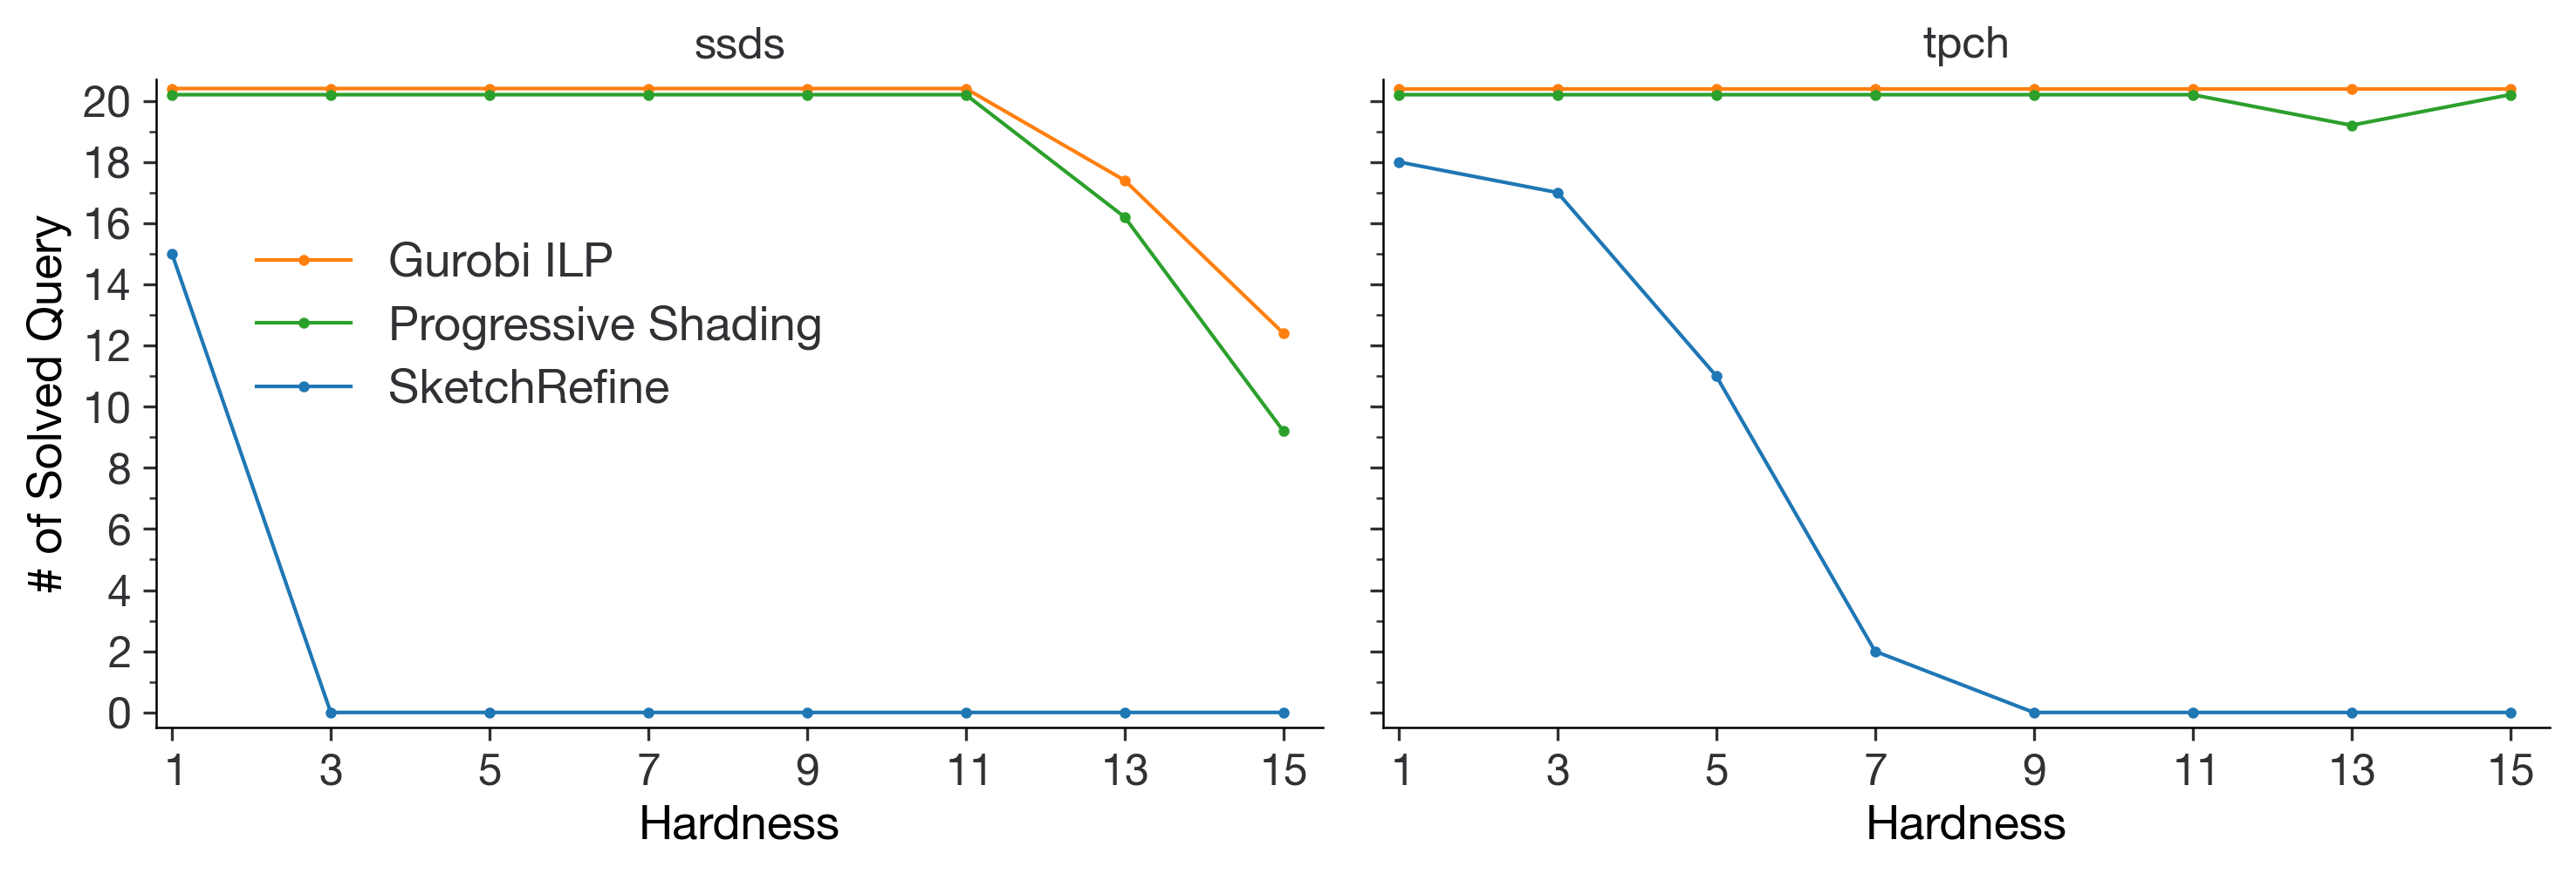

In [123]:
figsize=(10, 3.5)

data = pd.read_csv('A3.csv', names=['curve', 'x', 'y'])
data['solver'] = data['curve'].str.partition('_')[2].str.partition('_')[0]
data['dataset'] = data['curve'].str.partition('_')[0]
# data.curve.str.extract('^(?:[^_]*_){2}(.+)$')
data['dparam'] = data.curve.str.rpartition('_')[2]
df_err = data[data['dparam']=='igap']
df_acc = data[~(data['dparam']=='igap')]

df_acc_agg = df_acc.groupby(['dataset', 'solver', 'x', 'dparam'], as_index=False)['y'].sum()
df_err_bar = df_err.groupby(['dataset', 'solver', 'x'], as_index=False).agg([np.mean, np.max, np.min])
df_err_bar.columns = df_err_bar.columns.map('_'.join)
df_err_bar.reset_index(inplace=True)
df_err_bar['y_err_pos'] = df_err_bar['y_amax'] - df_err_bar['y_mean']
df_err_bar['y_err_neg'] = df_err_bar['y_mean'] - df_err_bar['y_amin']

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=figsize)
indexMap = {'GDR': 1, 'SR': 0, 'LSR': 2}
xticks = list(range(1, 16, 2))
dataset = ['ssds', 'tpch']

for i, D in enumerate(dataset):
    df_acc_d = df_acc_agg[df_acc_agg['dataset']==D]
    df_err_d = df_err
    ax = axs[i]
    df_gr = df_acc_d[(df_acc_d['solver']=='LSR') & (df_acc_d['dparam']=='P')]\
            .groupby(['dataset', 'solver', 'x'], as_index=False)['y'].sum()
    # Fitting GR solvability
    df_gr['y'] = 20
    if i == 0:
        df_gr.loc[6, 'y']=17
        df_gr.loc[7, 'y']=12
    df_lsr = df_acc_d[(df_acc_d['solver']=='LSR') & (df_acc_d['dparam']=='P')] \
            .groupby(['dataset', 'solver', 'x'], as_index=False)['y'].sum()
    df_sr = df_acc_d[(df_acc_d['solver']=='SR') & (df_acc_d['dparam']=='P')] \
            .groupby(['dataset', 'solver', 'x'], as_index=False)['y'].sum()
    
    # Impute missing data points explicitly with None value
    # if df_sr.shape[0] <= len(xticks):
    for x in xticks:
        new_row = pd.Series({'x': x, 'y': 0})
        if x not in df_sr.x.unique():
            df_sr = pd.concat([df_sr, new_row.to_frame().T], ignore_index=True)
        if x not in df_lsr.x.unique():
            df_lsr = pd.concat([df_lsr, new_row.to_frame().T], ignore_index=True)
        if x not in df_gr.x.unique():
            df_gr = pd.concat([df_gr, new_row.to_frame().T], ignore_index=True)
    
    ax.plot(
        df_gr['x'],
        df_gr['y']+0.4,
        color = colorWheel[indexMap['GDR']],
        linestyle=linestyle,
        lw=lw,
        marker=marker,
        markersize=markersize,
        markeredgecolor=colorWheel[indexMap['GDR']],
        label='Gurobi ILP'
    )
    ax.plot(
        df_lsr['x'],
        df_lsr['y']+0.2,
        color = colorWheel[indexMap['LSR']],
        lw=lw,
        linestyle=linestyle,
        marker=marker,
        markersize=markersize,
        markeredgecolor=colorWheel[indexMap['LSR']],
        label='Progressive Shading'
    )
    ax.plot(
        df_sr['x'],
        df_sr['y'],
        color = colorWheel[indexMap['SR']],
        lw=lw,
        linestyle=linestyle,
        marker=marker,
        markersize=markersize,
        markeredgecolor=colorWheel[indexMap['SR']],
        label='SketchRefine'
    )
    if i!=0:
        ax.yaxis.set_tick_params(labelleft=False)
    ax.set_title(D, loc='center')
    ax.set_ylim(top=20.7, bottom=-0.5)
    ax.set_yticks(range(0, 21, 2))
    ax.yaxis.set_minor_locator(AutoMinorLocator(2))
    ax.set_xlim(left=0.8, right=15.5)
    ax.set_xticks(xticks)

    df_err_d = df_err_bar[df_err_bar['dataset']==D]
    max_other = 0
    max_lsr = 0
#     for solver in ['LSR', 'SR']:
#         df_curve_err = df_err_d[df_err_d['solver']==solver]
#         ax1 = axs[1, i]
#         ax1.errorbar(
#                 df_curve_err['x'], 
#                 df_curve_err['y_mean'], 
#                 yerr=[df_curve_err['y_err_neg'], df_curve_err['y_err_pos']],
#                 color=colorWheel[indexMap[solver]],
#                 linestyle=linestyle,
#                 linewidth=lw,
#                 marker=marker,
#                 markersize=markersize,
#                 markeredgecolor=colorWheel[indexMap[solver]],
#                 capsize=capsize,
#                 capthick=capthick,
#                 elinewidth=elinewidth,
#                 ecolor=colorWheel[indexMap[solver]]
#             )
# #         if i!=0:
# #             ax1.yaxis.set_tick_params(labelleft=False)
#         #ax1.set_xscale('log', base=10)
#         ax1.yaxis.set_major_formatter(FuncFormatter('{:.5g}'.format))
#         if i==0:
#             ax1.set_yscale('log', base=10)
#             ax1.set_ylim([0.99, 50000])
#         else:
#             ax1.set_ylim([0.99, 1.25])
#         ax1.set_xticks(xticks)
#         ax1.set_xlabel("Hardness")
#         ax1.set_xlim(right=15.5)
#         if solver == 'SR':
#             max_other = df_curve_err['x'].max()
#         else:
#             max_lsr = df_curve_err['x'].max()
#     ax1.axvspan(max_other, max_lsr, facecolor=colorWheel[indexMap['LSR']], edgecolor='white', alpha=0.3)

axs[0].set_xlabel("Hardness")
axs[1].set_xlabel("Hardness")
axs[0].set_ylabel('# of Solved Query')
# axs[1].set_ylabel('Integrality Gap')
axs[0].legend(frameon=False, bbox_to_anchor=(0.6, 0.8))
plt.tight_layout()

[-5.13248444e-09 -1.26659569e-08 -2.00390144e-08 ... -1.35377508e-01
 -2.40671125e-01 -5.41510031e-01]
[-1.05875020e-09 -3.94617272e-09 -7.34724492e-09 ... -9.19102462e-02
 -1.08585983e-01 -1.13985713e-01]


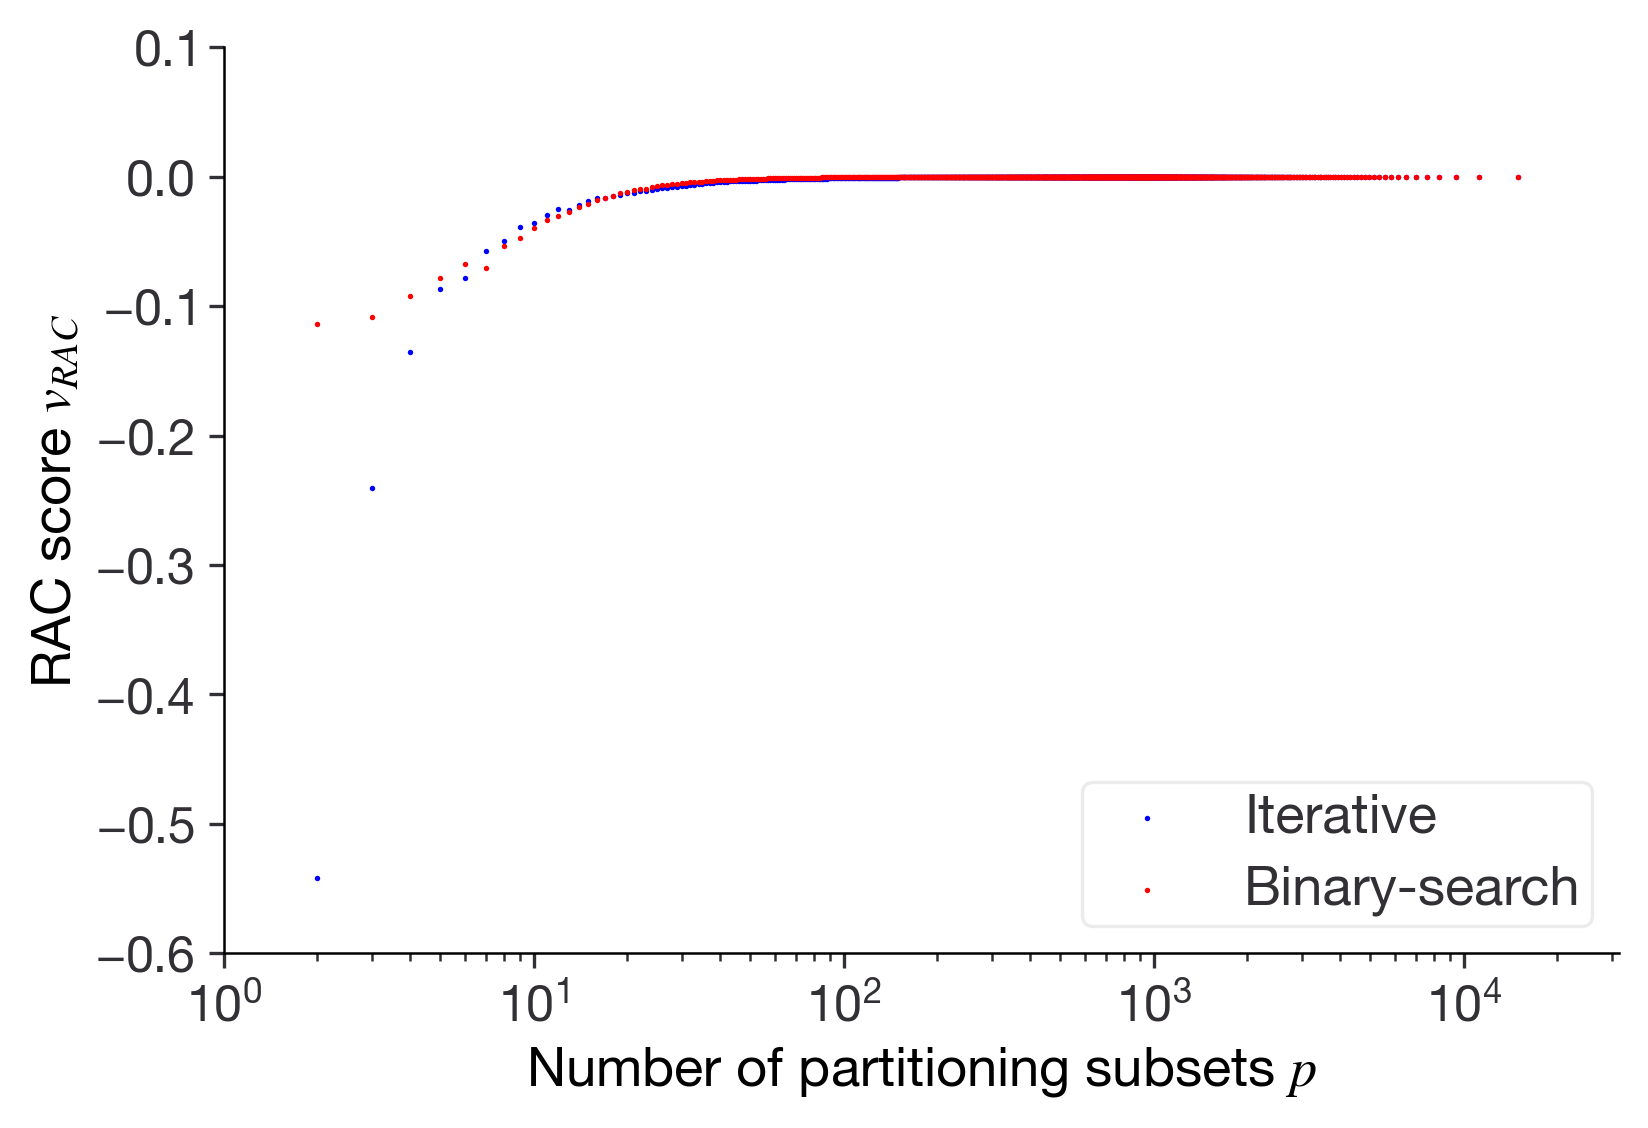

In [188]:
data = pd.read_csv('DLV3.csv', names=['curve', 'x', 'y'])
data.drop(data.tail(3).index,inplace=True)
p1 = data[data['curve']=='rac']
p2 = data[data['curve']=='rwc']
p = data[data['curve']=='p']
plt.xscale('log')
# y1, y2 = p1['y'], p2['y']
pp = np.multiply(p['y'], p['y']).to_numpy()
r = 1-1/pp
l1 = 1-np.divide(p1['y'].to_numpy(),pp)
l2 = 1-np.divide(p2['y'].to_numpy(),pp)
y1 = l1 - r
y2 = l2 - r
# y1 = np.add(1-np.divide(p1['y'].to_numpy(),pp), 1+1/(pp-1))
# y2 = np.add(1-np.divide(p2['y'].to_numpy(),pp), 1+1/(pp-1))
print(y1)
print(y2)
# y1 = 1/(1-y1)
# y2 = 1/(1-y2)
# y1 = np.clip(y1, 0, 1)
# y2 = np.clip(y2, 0, 1)
# print(max(np.isnan(y1)), max(np.isnan(y2)))
x = p['y'].to_numpy()
plt.scatter(x, y1, marker='.', s=1, color='blue', label=r'Iterative')
plt.scatter(x, y2, marker='.', s=1, color='red', label=r'Binary-search')
plt.legend()
plt.ylabel(r"RAC score $v_{RAC}$")
plt.xlabel(r"Number of partitioning subsets $p$")
plt.xlim(1, 10**4.5)
# plt.yscale('symlog')
# plt.yscale('logit')
plt.show()

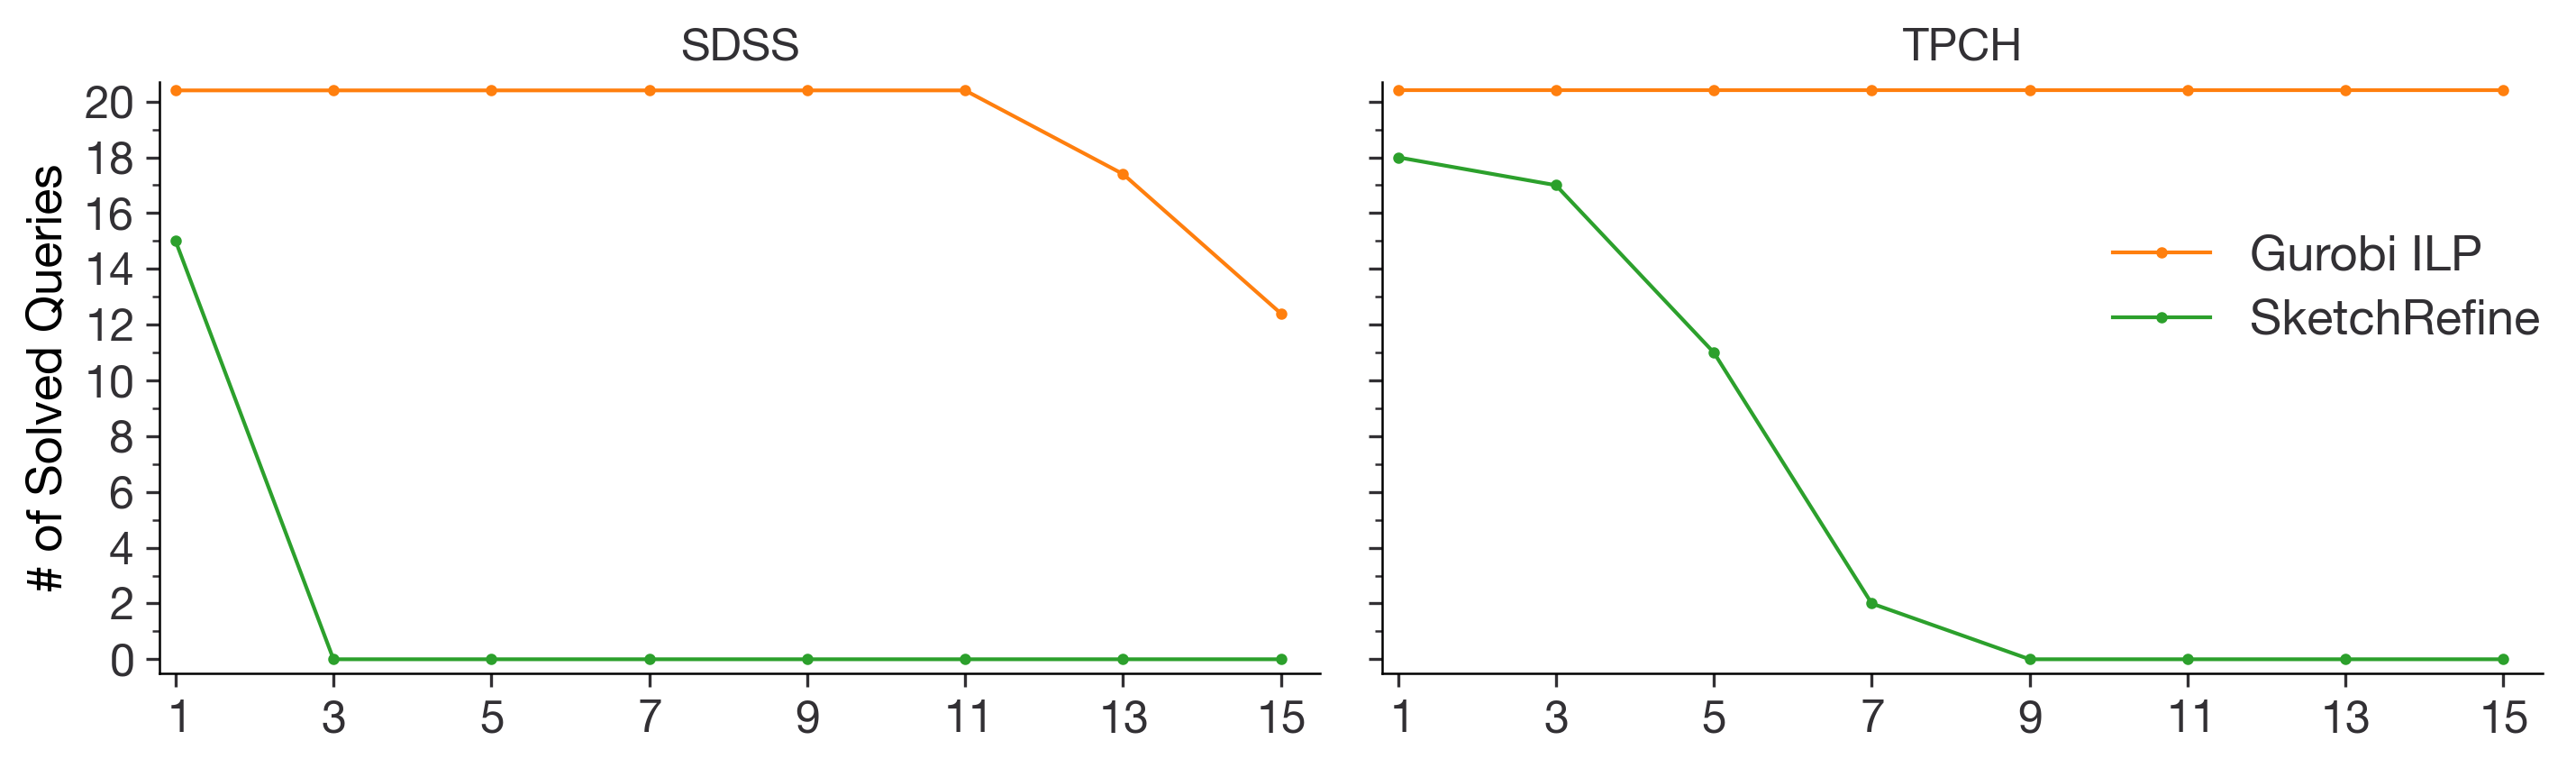

In [3]:
figsize=(10, 3)
data = pd.read_csv('A3.csv', names=['curve', 'x', 'y'])
data['solver'] = data['curve'].str.partition('_')[2].str.partition('_')[0]
data['dataset'] = data['curve'].str.partition('_')[0]
# data.curve.str.extract('^(?:[^_]*_){2}(.+)$')
data['dparam'] = data.curve.str.rpartition('_')[2]
df_err = data[data['dparam']=='igap']
df_acc = data[~(data['dparam']=='igap')]

df_acc_agg = df_acc.groupby(['dataset', 'solver', 'x', 'dparam'], as_index=False)['y'].sum()
df_err_bar = df_err.groupby(['dataset', 'solver', 'x'], as_index=False).agg([np.mean, np.max, np.min])
df_err_bar.columns = df_err_bar.columns.map('_'.join)
df_err_bar.reset_index(inplace=True)
df_err_bar['y_err_pos'] = df_err_bar['y_amax'] - df_err_bar['y_mean']
df_err_bar['y_err_neg'] = df_err_bar['y_mean'] - df_err_bar['y_amin']

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=figsize)
xticks = list(range(1, 16, 2))
dataset = ['ssds', 'tpch']
names = ['SDSS', 'TPCH']

for i, D in enumerate(dataset):
    df_acc_d = df_acc_agg[df_acc_agg['dataset']==D]
    df_err_d = df_err
#    ax = axs[0, i]
    ax = axs[i]
    df_gr = df_acc_d[(df_acc_d['solver']=='LSR') & (df_acc_d['dparam']=='P')]\
            .groupby(['dataset', 'solver', 'x'], as_index=False)['y'].sum()
    # Fitting GR solvability
    df_gr['y'] = 20
    if i == 0:
        df_gr.loc[6, 'y']=17
        df_gr.loc[7, 'y']=12
    df_lsr = df_acc_d[(df_acc_d['solver']=='LSR') & (df_acc_d['dparam']=='P')] \
            .groupby(['dataset', 'solver', 'x'], as_index=False)['y'].sum()
    df_sr = df_acc_d[(df_acc_d['solver']=='SR') & (df_acc_d['dparam']=='P')] \
            .groupby(['dataset', 'solver', 'x'], as_index=False)['y'].sum()
    
    # Impute missing data points explicitly with None value
    # if df_sr.shape[0] <= len(xticks):
    for x in xticks:
        new_row = pd.Series({'x': x, 'y': 0})
        if x not in df_sr.x.unique():
            df_sr = pd.concat([df_sr, new_row.to_frame().T], ignore_index=True)
        if x not in df_lsr.x.unique():
            df_lsr = pd.concat([df_lsr, new_row.to_frame().T], ignore_index=True)
        if x not in df_gr.x.unique():
            df_gr = pd.concat([df_gr, new_row.to_frame().T], ignore_index=True)
    
    ax.plot(
        df_gr['x'],
        df_gr['y']+0.4,
        color = colorWheel[indexMap['GDR']],
        linestyle=linestyle,
        lw=lw,
        marker=marker,
        markersize=markersize,
        markeredgecolor=colorWheel[indexMap['GDR']],
        label='Gurobi ILP'
    )
#     ax.plot(
#         df_lsr['x'],
#         df_lsr['y']+0.2,
#         color = colorWheel[indexMap['LSR']],
#         lw=lw,
#         linestyle=linestyle,
#         marker=marker,
#         markersize=markersize,
#         markeredgecolor=colorWheel[indexMap['LSR']],
#         label='Progressive Shading'
#     )
    ax.plot(
        df_sr['x'],
        df_sr['y'],
        color = colorWheel[indexMap['SR']],
        lw=lw,
        linestyle=linestyle,
        marker=marker,
        markersize=markersize,
        markeredgecolor=colorWheel[indexMap['SR']],
        label='SketchRefine'
    )
    if i!=0:
        ax.yaxis.set_tick_params(labelleft=False)
    ax.set_title(names[i], loc='center')
    ax.set_ylim(top=20.7, bottom=-0.5)
    ax.set_yticks(range(0, 21, 2))
    ax.yaxis.set_minor_locator(AutoMinorLocator(2))
    ax.set_xlim(left=0.8, right=15.5)
    ax.set_xticks(xticks)

#     df_err_d = df_err_bar[df_err_bar['dataset']==D]
#     max_other = 0
#     max_lsr = 0
#     for solver in ['LSR', 'SR']:
#         df_curve_err = df_err_d[df_err_d['solver']==solver]
#         ax1 = axs[1, i]
#         ax1.errorbar(
#                 df_curve_err['x'], 
#                 df_curve_err['y_mean'], 
#                 yerr=[df_curve_err['y_err_neg'], df_curve_err['y_err_pos']],
#                 color=colorWheel[indexMap[solver]],
#                 linestyle=linestyle,
#                 linewidth=lw,
#                 marker=marker,
#                 markersize=markersize,
#                 markeredgecolor=colorWheel[indexMap[solver]],
#                 capsize=capsize,
#                 capthick=capthick,
#                 elinewidth=elinewidth,
#                 ecolor=colorWheel[indexMap[solver]]
#             )
# #         if i!=0:
# #             ax1.yaxis.set_tick_params(labelleft=False)
#         #ax1.set_xscale('log', base=10)
#         ax1.yaxis.set_major_formatter(FuncFormatter('{:.5g}'.format))
#         if i==0:
#             ax1.set_yscale('log', base=10)
#             ax1.set_ylim([0.99, 50000])
#         else:
#             ax1.set_ylim([0.99, 1.25])
#         ax1.set_xticks(xticks)
#         ax1.set_xlabel("Hardness")
#         ax1.set_xlim(right=15.5)
#         if solver == 'SR':
#             max_other = df_curve_err['x'].max()
#         else:
#             max_lsr = df_curve_err['x'].max()
#     ax1.axvspan(max_other, max_lsr, facecolor=colorWheel[indexMap['LSR']], edgecolor='white', alpha=alpha)
        
axs[0].set_ylabel('# of Solved Queries')
#axs[1].set_ylabel('Integrality Gap')
axs[1].legend(frameon=False, bbox_to_anchor=(0.6, 0.8))
plt.tight_layout()
#plt.savefig('A3_sr_only.pdf')

/usr/local/lib/python3.8/dist-packages/numpy/core/function_base.py:277: RuntimeWarning: overflow encountered in power
  return _nx.power(base, y)


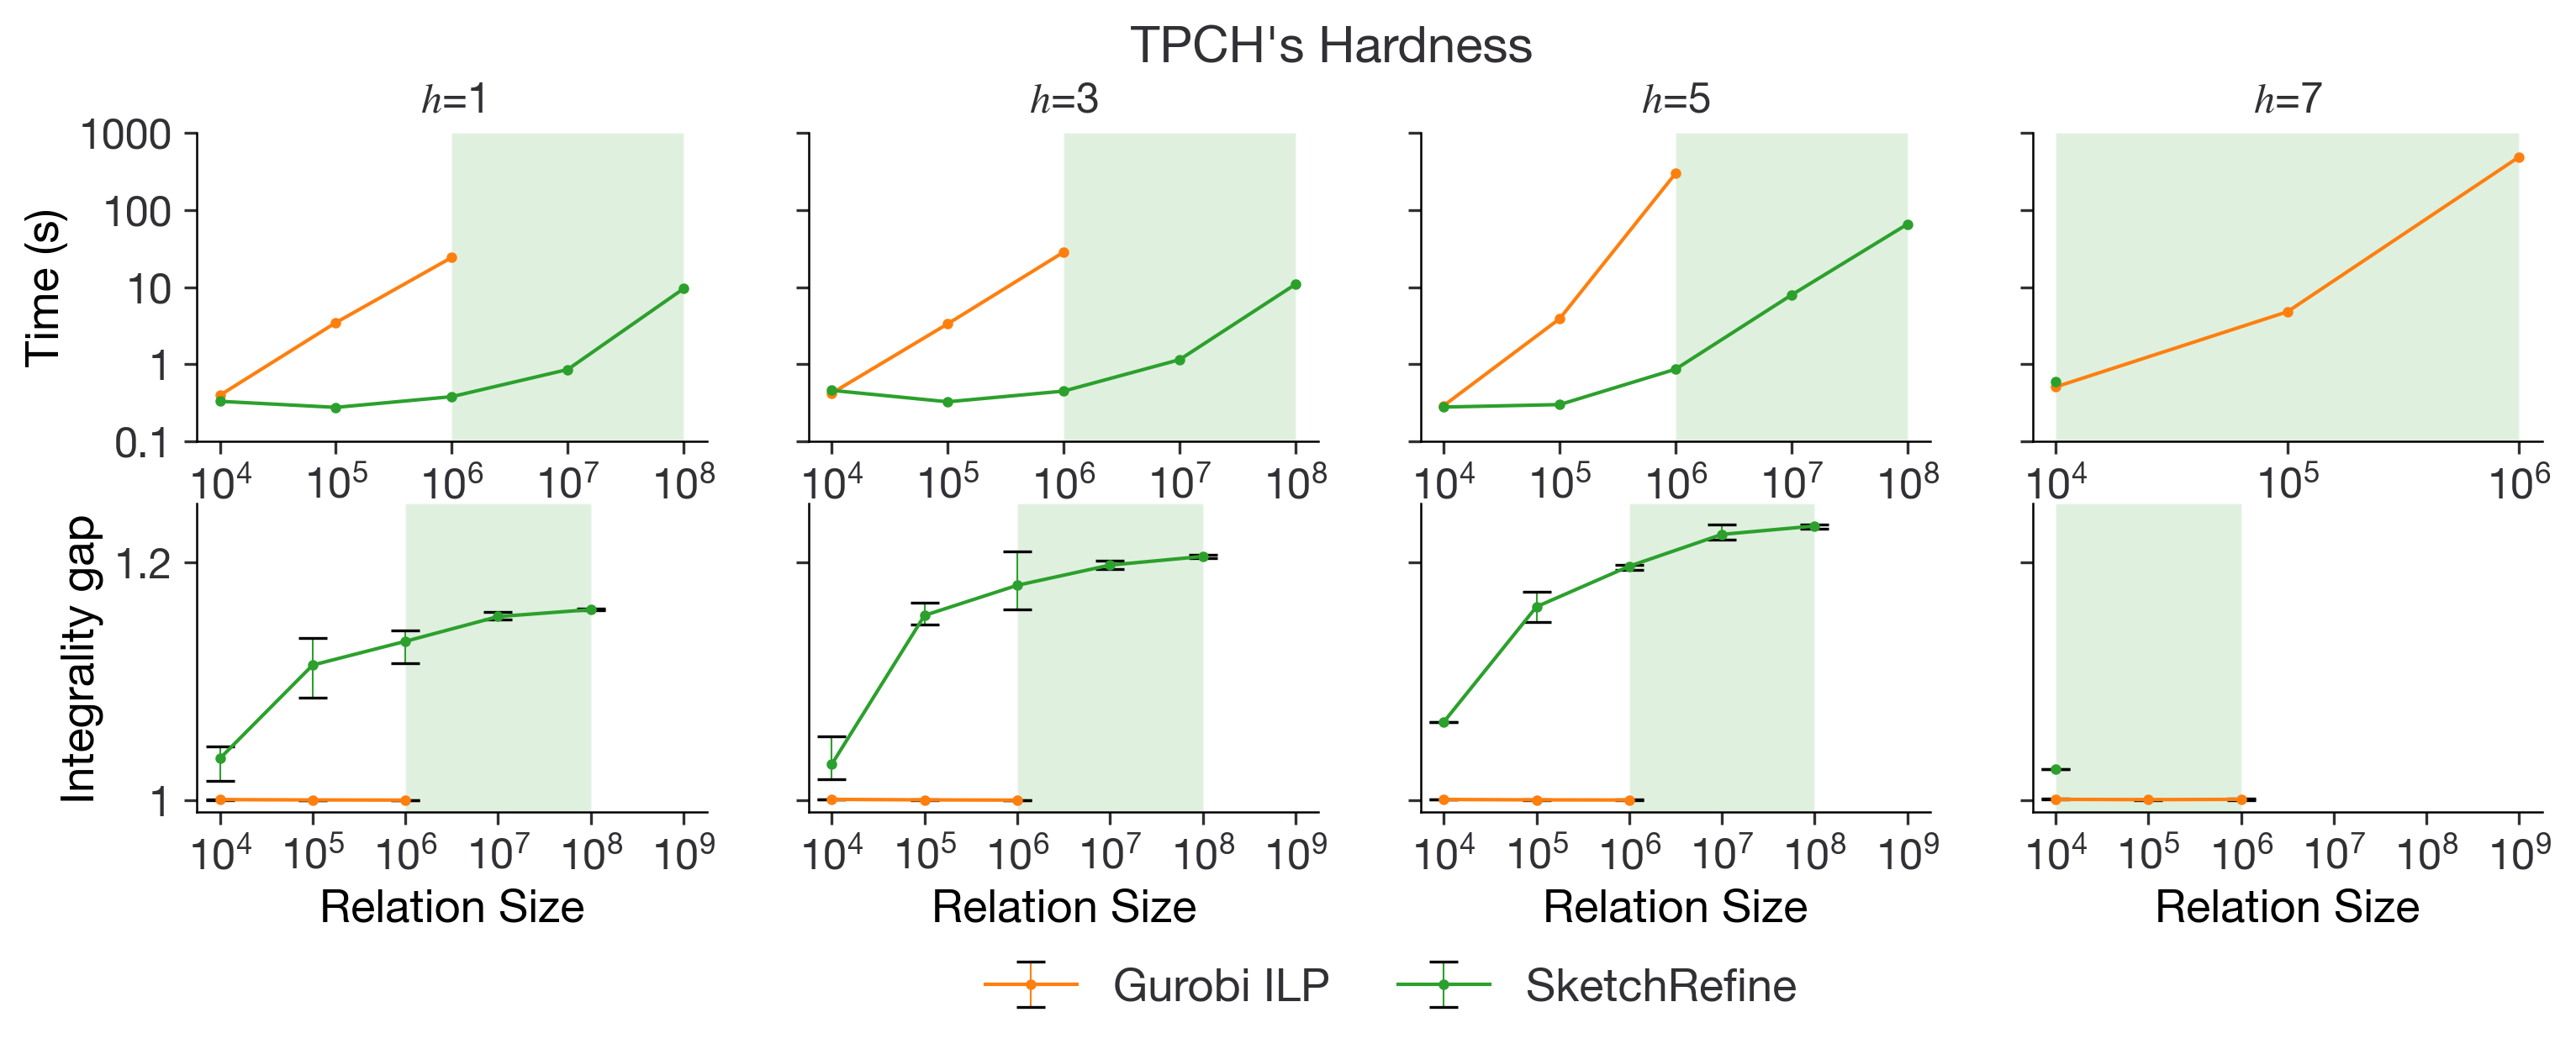

In [19]:
figsize=(12, 3.5)
csv_file = 'A4_tpch.csv'
is_ssds = 'ssds' in csv_file
data = pd.read_csv(csv_file, names=['curve', 'x', 'y'])
#data['x'] = dta['x'].astype(int)
data['solver'] = data['curve'].str.rpartition('_')[0].str.rpartition('_')[2]
data['H'] = data['curve'].str.rpartition('_H')[2].str.partition('_')[0]
df_time = data[data['curve'].str.contains('time')]
df_err = data[data['curve'].str.contains('igap')]

df_time_avg = df_time.groupby(['solver', 'H', 'x'], as_index=False).mean()
df_err_avg = df_err.groupby(['solver', 'H', 'x'], as_index=False).mean()
#df_err.y = df_err.y * 100
df_err_bar = df_err.groupby(['solver', 'H', 'x'], as_index=False).agg([np.mean, np.max, np.min])
df_err_bar.columns = df_err_bar.columns.map('_'.join)
df_err_bar.reset_index(inplace=True)
df_err_bar['y_err_pos'] = df_err_bar['y_amax'] - df_err_bar['y_mean']
df_err_bar['y_err_neg'] = df_err_bar['y_mean'] - df_err_bar['y_amin']

num_hardness = data['H'].nunique()
fig, axs = plt.subplots(nrows=2, ncols=num_hardness, figsize=figsize)
xticks = df_time['x'].unique()
s_pos = np.array([np.logspace(0.8*x, 1.2*x, num=3) for x in xticks])

for idx, h in enumerate(data['H'].unique()):
    df_h = df_time_avg[df_time_avg['H'] == h]
    df_h_err = df_err_bar[df_err_avg['H'] == h]
    ax = axs[0, idx]
    ax1 = axs[1, idx]
    max_other = 0
    for i, curve in enumerate(df_h['solver'].unique()):
        if curve=='LSR':
            continue
        df_curve = df_h[df_h['solver'] == curve]
        df_curve_err = df_h_err[df_h_err['solver'] == curve]
        ax.plot(
            #df_curve['x']*xOffsetMap[indexMap[curve]],
            df_curve['x'],
            df_curve['y']/1000,
            color=colorWheel[indexMap[curve]],
            linestyle=linestyle,
            linewidth=lw,
            marker=marker,
            markersize=markersize,
            markeredgecolor=colorWheel[indexMap[curve]],
            label=curve_names[curve]
        )
        if idx!=0:
            ax.yaxis.set_tick_params(labelleft=False)
        ax.set_xscale('log', base=10)
        ax.set_yscale('log', base=10)
        ax.yaxis.set_major_formatter(ScalarFormatter())
        ax.tick_params(axis='x', which='major')
        #ax.set_xlabel('Relation Size')
        ax.set_ylim(bottom=0.1, top=10e2)
        ax.yaxis.set_major_formatter(FuncFormatter('{:.4g}'.format))
        #ax.yaxis.set_major_formatter(StrMethodFormatter('{x:.1f}'))
        #ax.yaxis.set_tick_params()
        ax.set_xticks(df_time['x'].unique())
        ax.set_title(f'$h$={h}', loc='center')
        ax.minorticks_off()
        if curve == 'SR':
            max_sr = df_curve['x'].max()
        else:
            max_other = max(df_curve['x'].max(), max_other)
        
        # Percentage Error Bar
        
        # Impute missing data points explicitly with None value
        if df_curve_err.shape[0] <= len(xticks):
            for x in xticks:
                if x not in df_curve_err.x.unique():
                    new_row = pd.Series({'solver': curve, 'x': x, 'H': h})
                    df_curve_err = pd.concat([df_curve_err, new_row.to_frame().T], ignore_index=True)
        df_curve_err.sort_values(['x'], inplace=True)
        
#         print("h", h)
#         print(df_curve_err['y_mean'])

        ax1.errorbar(
            df_curve_err['x'], 
            df_curve_err['y_mean'], 
            yerr=[df_curve_err['y_err_neg'], df_curve_err['y_err_pos']],
            color=colorWheel[indexMap[curve]],
            linestyle=linestyle,
            linewidth=lw,
            marker=marker,
            markersize=markersize,
            markeredgecolor=colorWheel[indexMap[curve]],
            capsize=capsize,
            capthick=capthick,
            elinewidth=elinewidth,
            ecolor=colorWheel[indexMap[curve]],
            label=curve_names[curve]
        )
        if idx!=0:
            ax1.yaxis.set_tick_params(labelleft=False)
        ax1.set_xscale('log', base=10)
        if is_ssds:
            ax1.set_yscale('log', base=10)
        ax1.yaxis.set_major_formatter(FuncFormatter('{:.5g}'.format))
        ax1.set_xticks(df_time['x'].unique())
#         ax1.set_xlabels(['10e4', '10e5', '10e6', '10e7', '10e8', '10e9'])
#         ax1.ticklabel_format(axis='x', stylr='sci')
        ax1.tick_params(axis='x', which='major')
        ax1.set_xlabel('Relation Size')
        if is_ssds:
            ax1.set_ylim(bottom=0.9, top=1e5)
        else:
            ax1.set_ylim(bottom=0.99, top=1.25)
    ax.axvspan(max_other, max_sr, facecolor=colorWheel[indexMap['SR']], edgecolor='white', alpha=alpha)
    ax1.axvspan(max_other, max_sr, facecolor=colorWheel[indexMap['SR']], edgecolor='white', alpha=alpha)
          
axs[0, 0].set_ylabel('Time (s)')
#axs[0, 0].set_yticks([10])
axs[1, 0].set_ylabel('Integrality gap')
axs[1, 1].legend(frameon=False, bbox_to_anchor=(2, -0.4), ncols=3)
#axs[0, 0]
fig.supxlabel('TPCH\'s Hardness', x=0.5, y=0.95)
# plt.tight_layout()
fig.savefig('tpch_sr_g.pdf', transparent=True, bbox_inches='tight')